## 5.3、5.4  PyTorchでDQN

In [1]:
# パッケージのimport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym


In [2]:
# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DQN.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))
    

In [3]:
# 本コードでは、namedtupleを使用します。
# namedtupleを使うことで、値をフィールド名とペアで格納できます。
# すると値に対して、フィールド名でアクセスできて便利です。
# https://docs.python.jp/3/library/collections.html#collections.namedtuple
# 以下は使用例です

from collections import namedtuple

# 各ステップでのtransition(経験)をnamedtupleで変換
Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('名前Aです', 100)

print(Tr_object)  # 出力：tr(name_a='名前Aです', value_b=100)
print(Tr_object.value_b)  # 出力：100


tr(name_a='名前Aです', value_b=100)
100


In [4]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


In [5]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
GAMMA = 0.99  # 時間割引率
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 500  # 最大試行回数


In [6]:
# 経験を保存するメモリクラスを定義します


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす
        #　メモリがいっぱいになったら古い内容から上書き

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)


In [7]:
# エージェントが持つ脳となるクラスです、DQNを実行します、DQNの中心部　
# Q関数をディープラーニングのネットワークをクラスとして定義

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい場合は終了
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])
        # 次の状態があるかでQ学習の更新式も変わる
        # non_final_next_states = 次の状態が存在する状態だけを集めたミニバッチ

        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 教師信号＝ネットワークが本来出力して欲しい値
        # 3.1 Q値を求めるためにネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)
        # 実際にNNが出力したQ(s_t,a_t)
        
        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        non_final_mask = non_final_mask.type(torch.bool)
        #torchバージョン問題で型変換
        
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        # 次の状態が存在しない場合は０
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        # detach() 値を取り出す、その変数が保持しているそれまでの計算履歴を失いbpする際に微分計算しなくなる。
        # 教師信号は固定されたものである必要があるので微分操作が行われないようにする
        # 予測として出力したQ(s_t,a_t)はdetachしない
        
        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_loss=Huberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action

In [8]:
# CartPoleで動くエージェントクラスです、棒付き台車そのものになります


class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        # 経験したデータ(trainsition)を格納
        self.brain.memory.push(state, action, state_next, reward)


In [9]:
# CartPoleを実行する環境のクラスです


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

        
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数

        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # NumPy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))

                action = self.agent.get_action(state, episode)  # 行動を求める

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(
                    action.item())  # rewardとinfoは使わないので_にする

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break

            # 10連続で200step経ち続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする


Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 16 steps：10試行の平均step数 = 1.6
1 Episode: Finished after 13 steps：10試行の平均step数 = 2.9
2 Episode: Finished after 11 steps：10試行の平均step数 = 4.0
3 Episode: Finished after 9 steps：10試行の平均step数 = 4.9
4 Episode: Finished after 8 steps：10試行の平均step数 = 5.7
5 Episode: Finished after 10 steps：10試行の平均step数 = 6.7
6 Episode: Finished after 9 steps：10試行の平均step数 = 7.6
7 Episode: Finished after 11 steps：10試行の平均step数 = 8.7
8 Episode: Finished after 9 steps：10試行の平均step数 = 9.6
9 Episode: Finished after 10 steps：10試行の平均step数 = 10.6
10 Episode: Finished after 9 steps：10試行の平均step数 = 9.9
11 Episode: Finished after 9 steps：10試行の平均step数 = 9.5
12 Episode: Finished after 10 steps：10試行の平均step数 = 9.4
13 Episode: Finished after 10 steps：10試行の平均step数 = 9.5
14 Episode: Finis

143 Episode: Finished after 64 steps：10試行の平均step数 = 93.8
144 Episode: Finished after 76 steps：10試行の平均step数 = 84.5
145 Episode: Finished after 71 steps：10試行の平均step数 = 85.0
146 Episode: Finished after 74 steps：10試行の平均step数 = 85.4
147 Episode: Finished after 76 steps：10試行の平均step数 = 81.3
148 Episode: Finished after 140 steps：10試行の平均step数 = 88.1
149 Episode: Finished after 70 steps：10試行の平均step数 = 87.8
150 Episode: Finished after 62 steps：10試行の平均step数 = 87.8
151 Episode: Finished after 71 steps：10試行の平均step数 = 78.8
152 Episode: Finished after 76 steps：10試行の平均step数 = 78.0
153 Episode: Finished after 54 steps：10試行の平均step数 = 77.0
154 Episode: Finished after 58 steps：10試行の平均step数 = 75.2
155 Episode: Finished after 75 steps：10試行の平均step数 = 75.6
156 Episode: Finished after 109 steps：10試行の平均step数 = 79.1
157 Episode: Finished after 58 steps：10試行の平均step数 = 77.3
158 Episode: Finished after 66 steps：10試行の平均step数 = 69.9
159 Episode: Finished after 64 steps：10試行の平均step数 = 69.3
160 Episode: Finished after 8


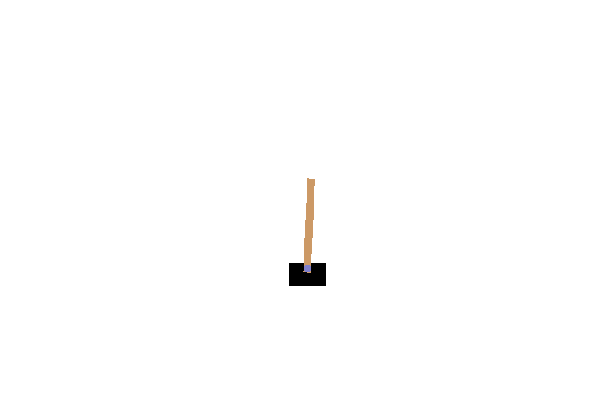
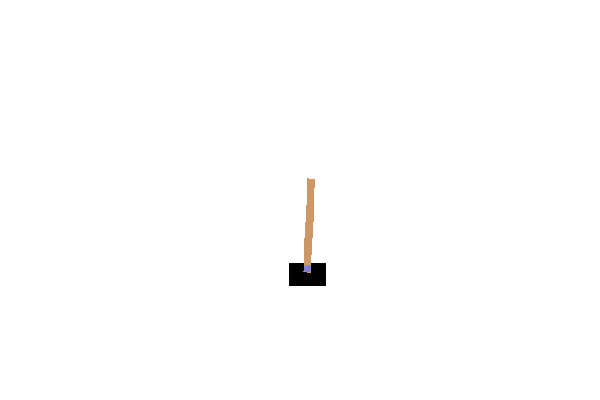
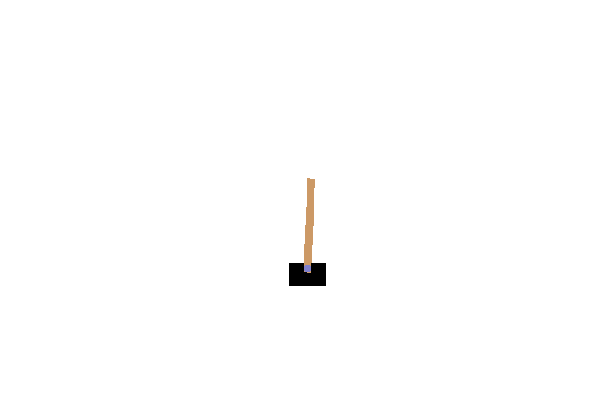
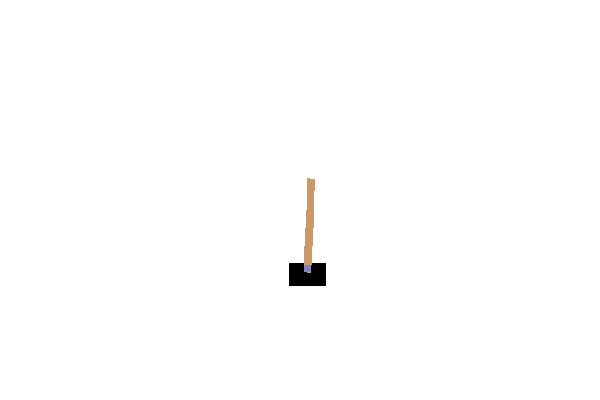
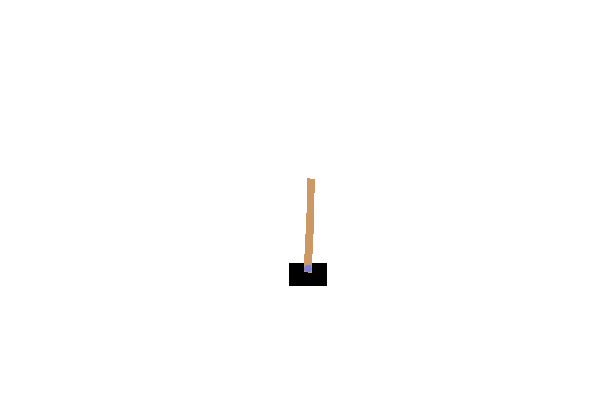
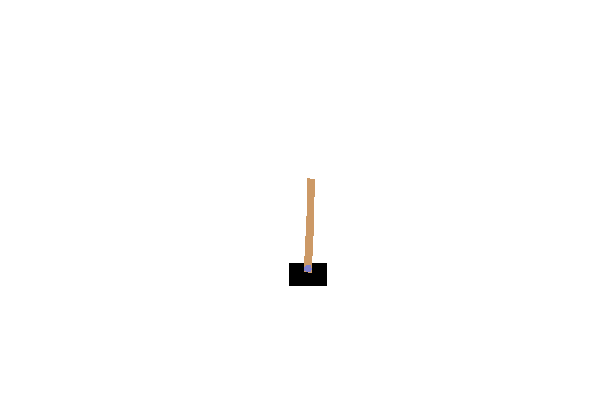
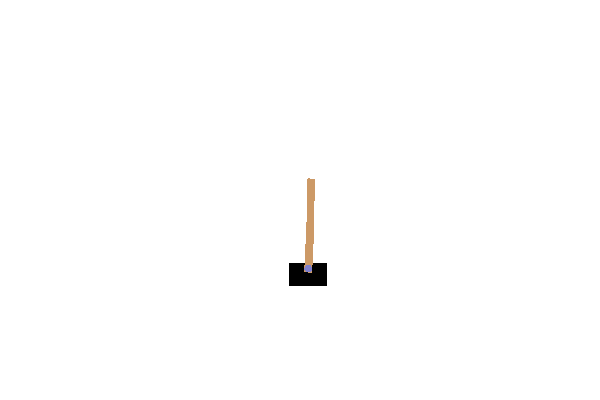
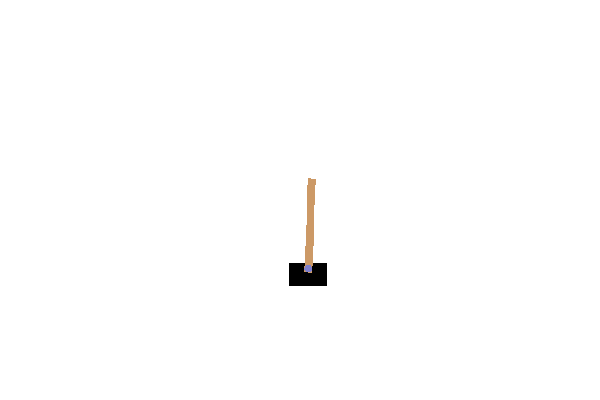
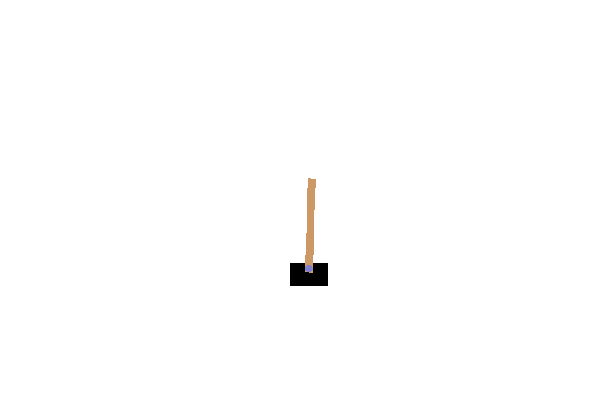
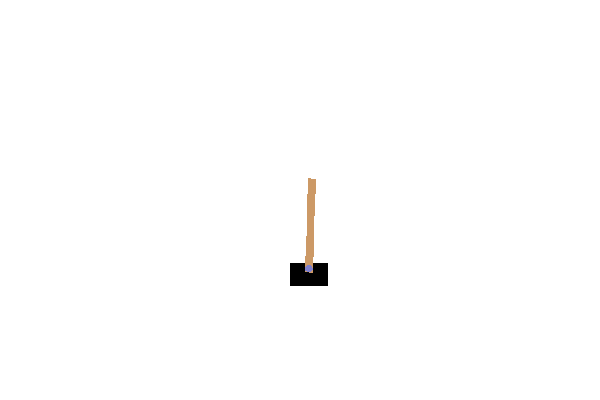
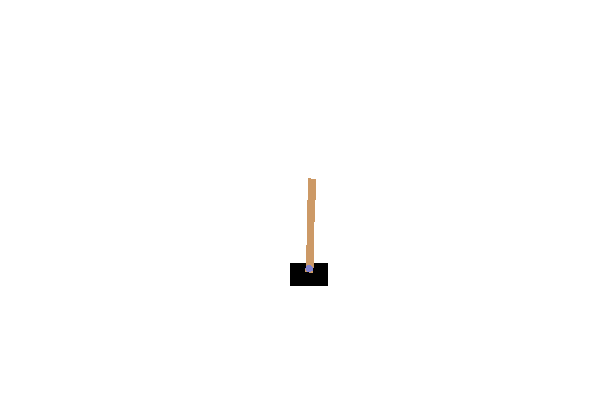
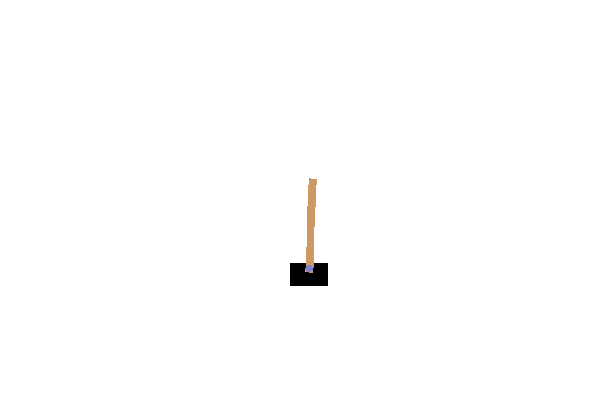
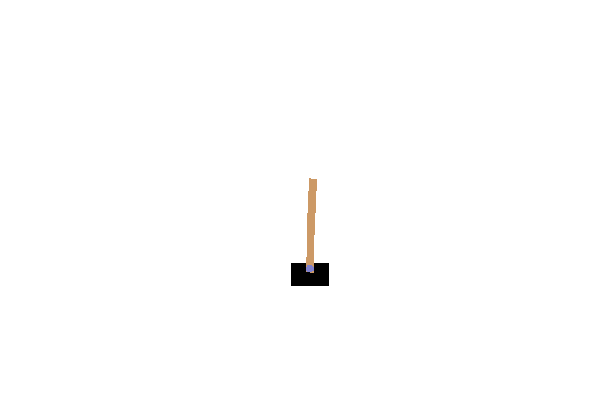
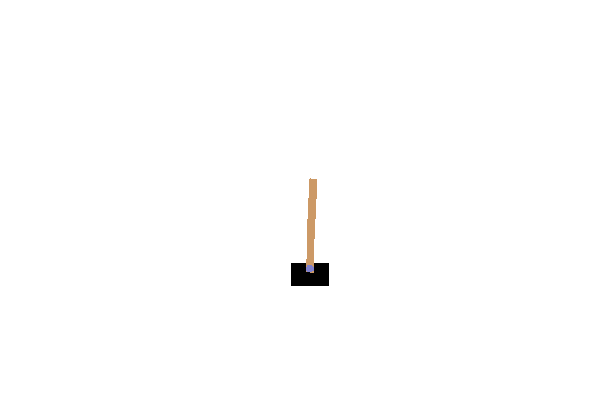
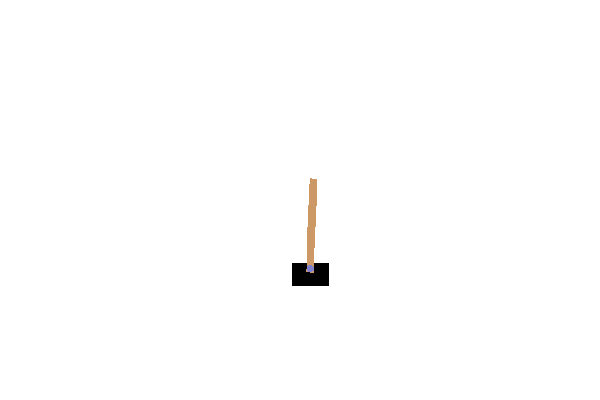
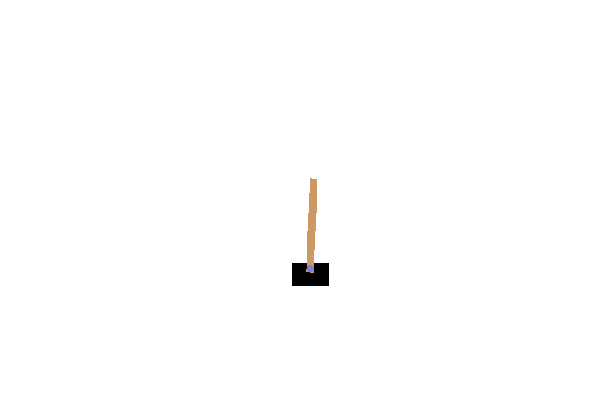
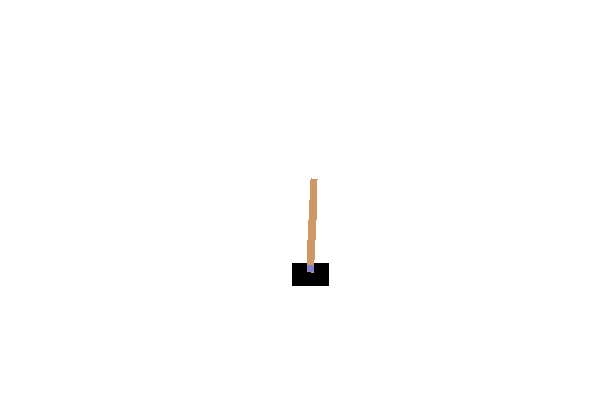
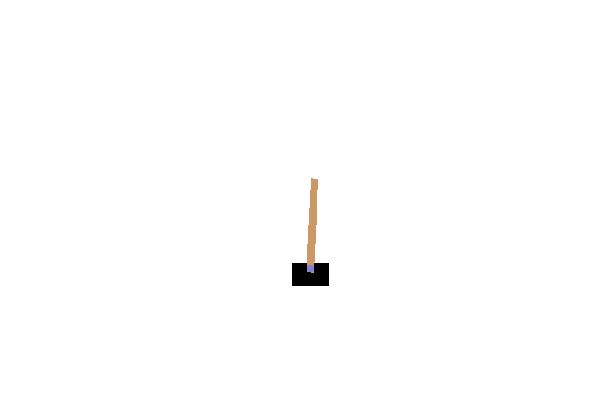
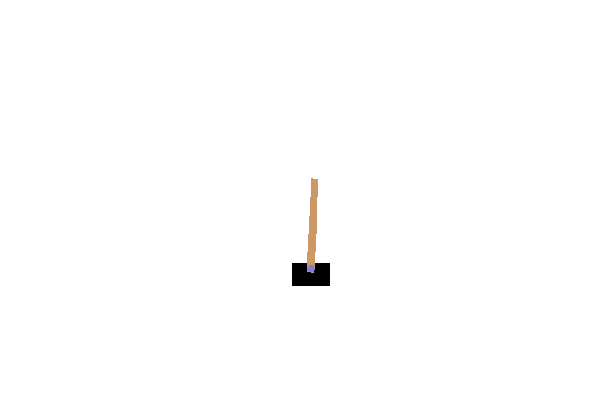
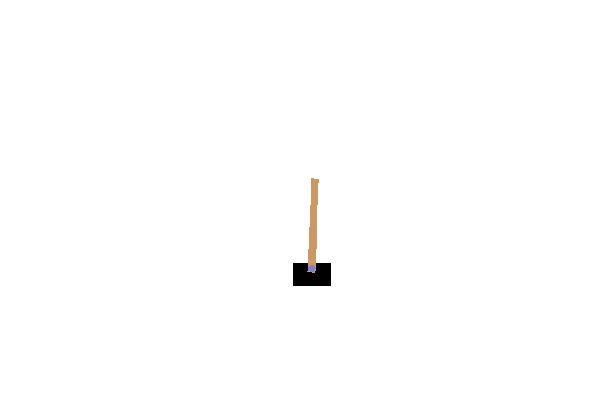
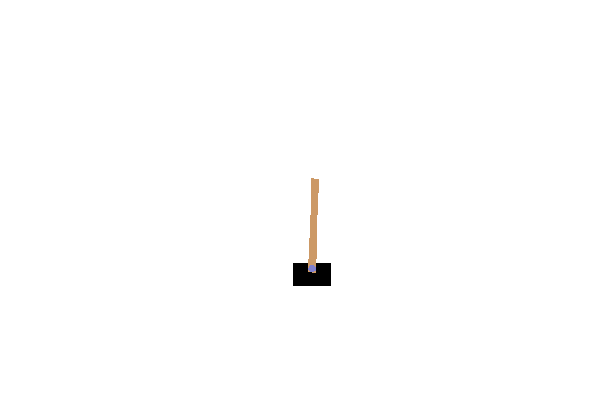
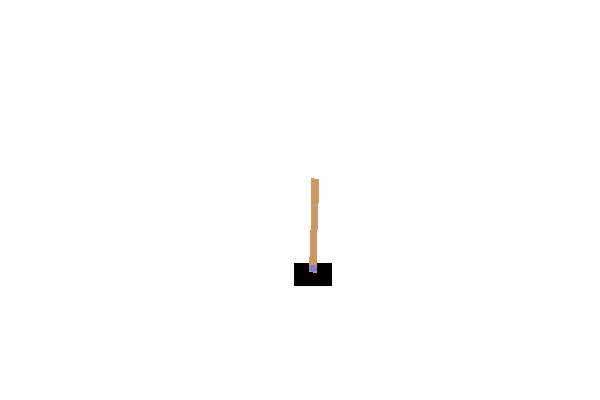
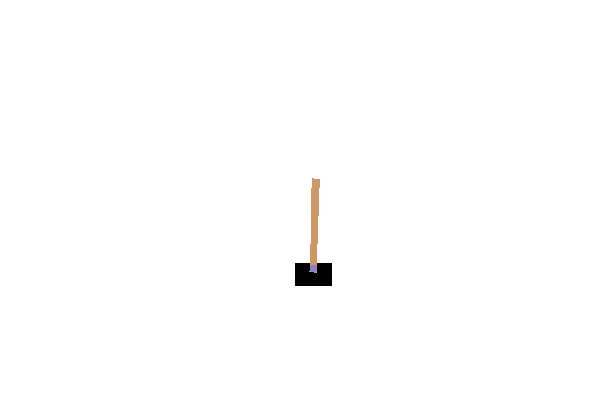
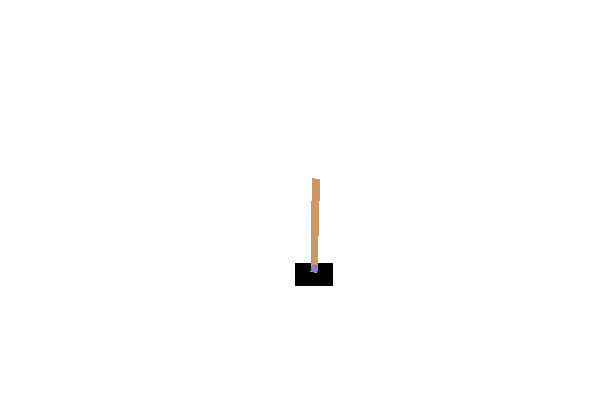
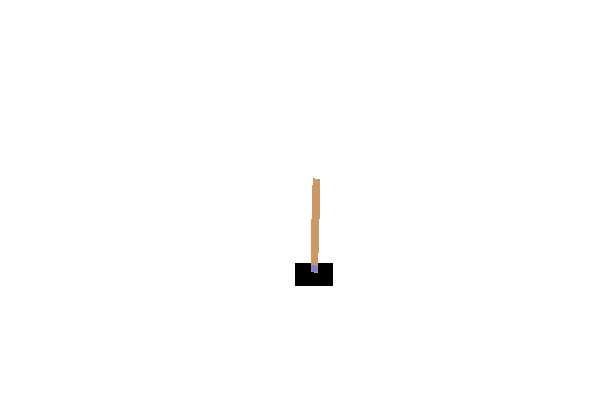
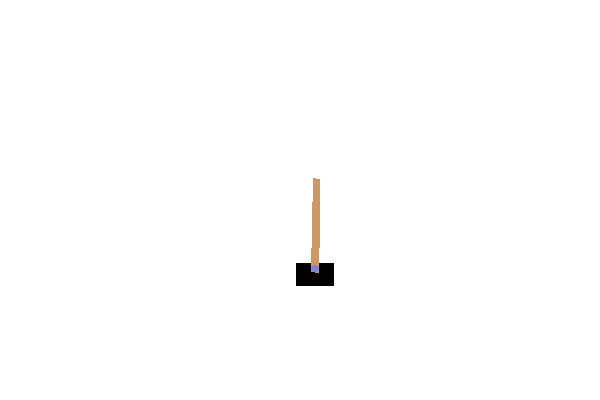
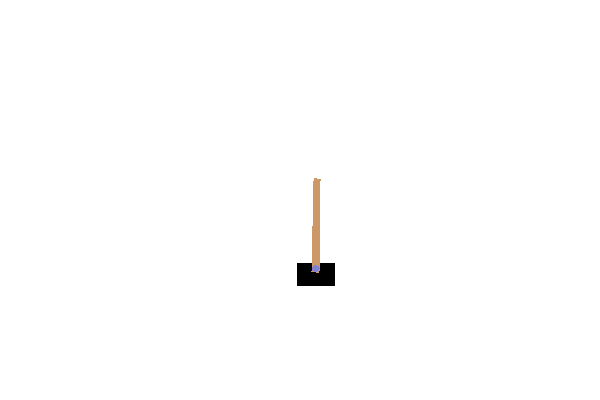
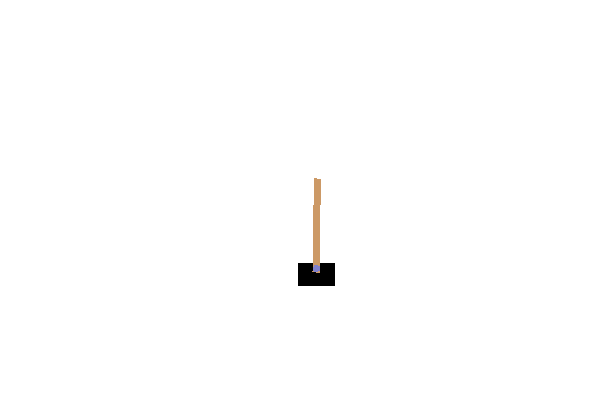
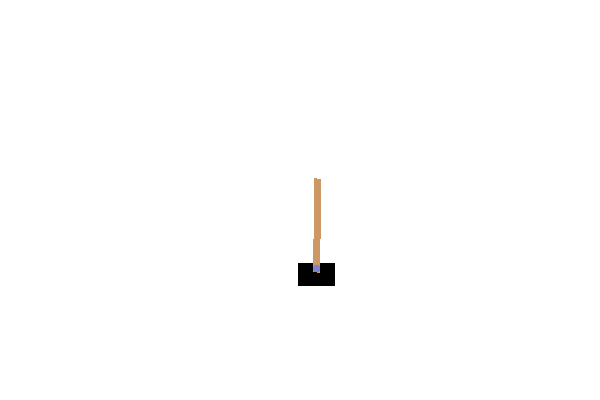
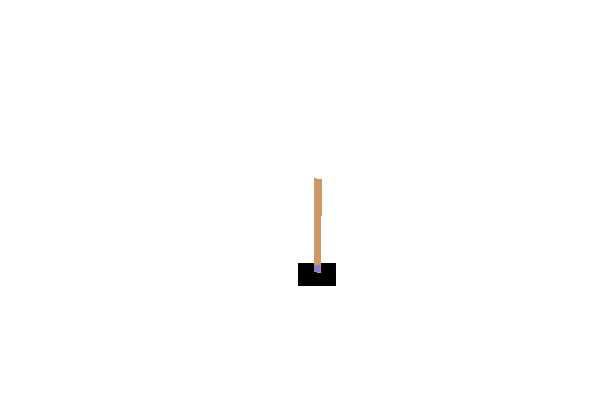
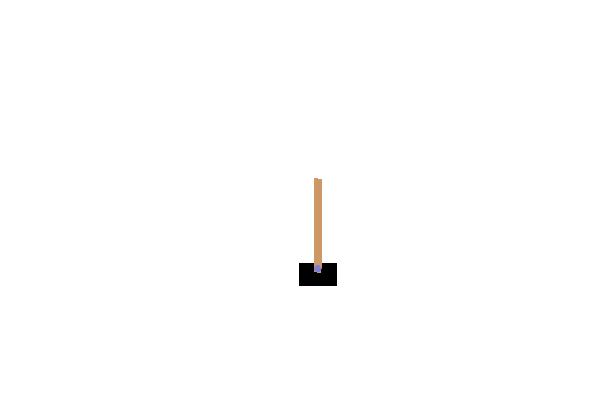
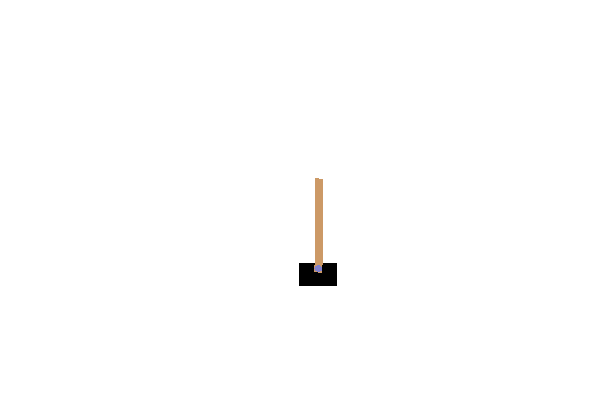
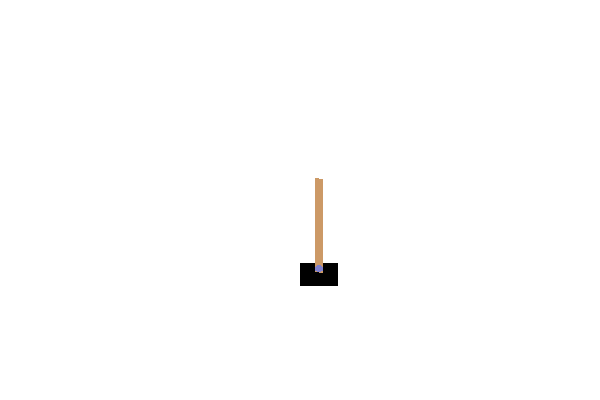
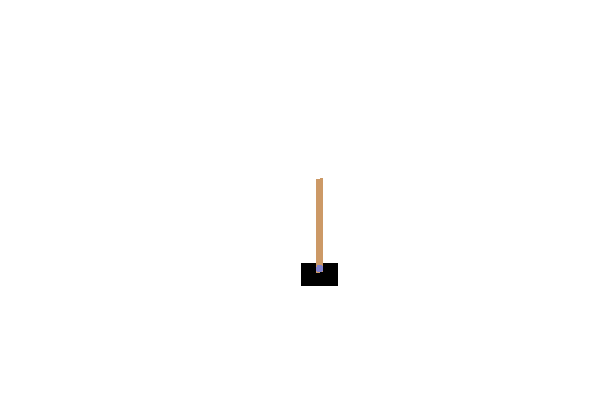
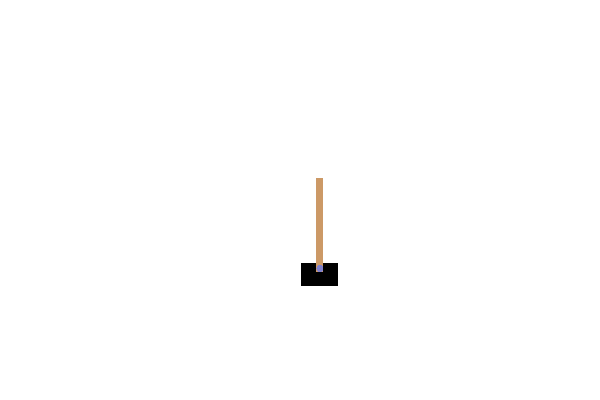
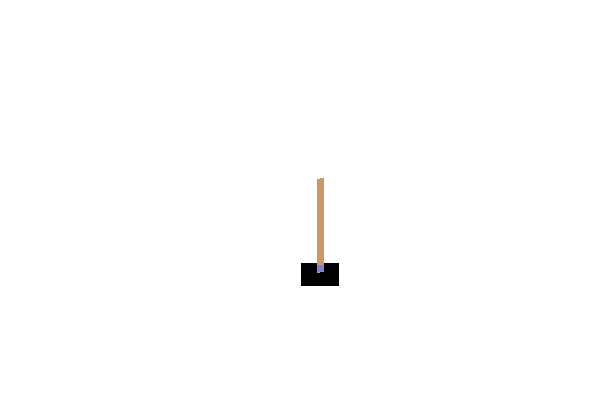
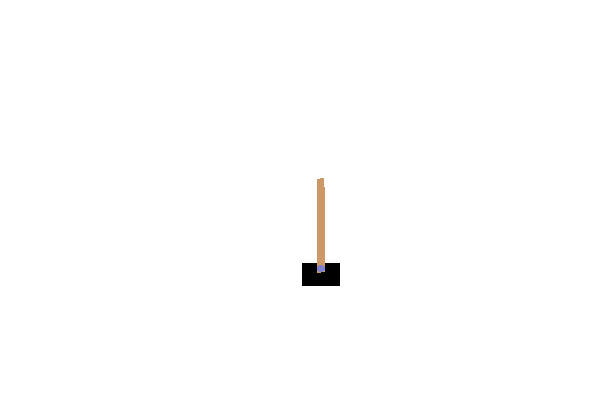
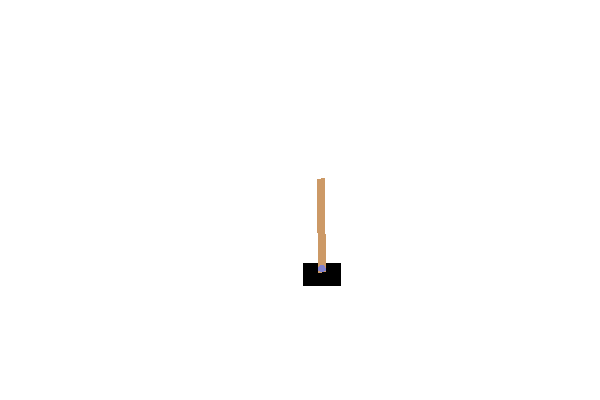
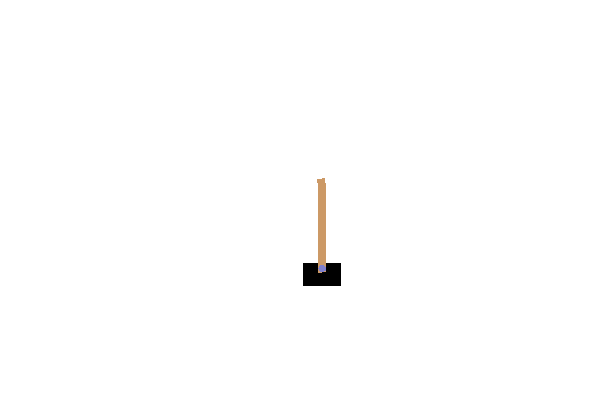
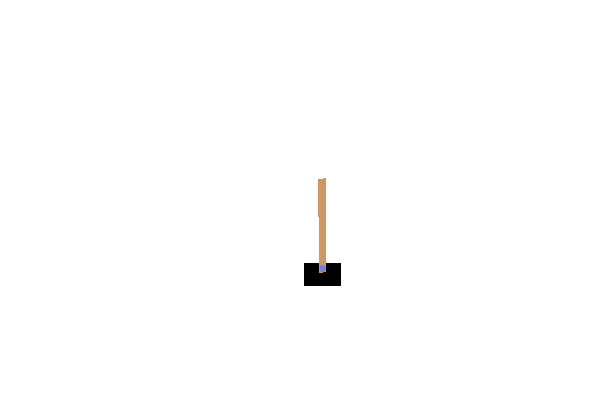
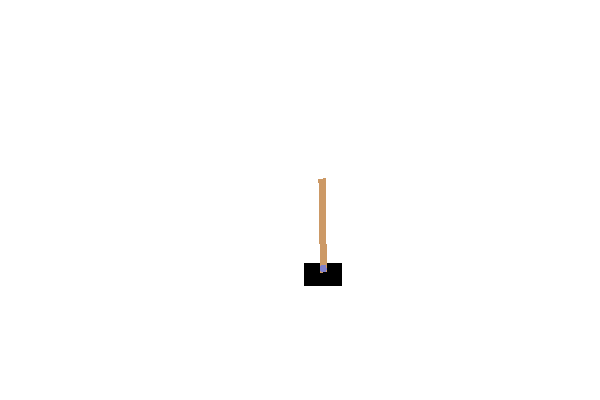
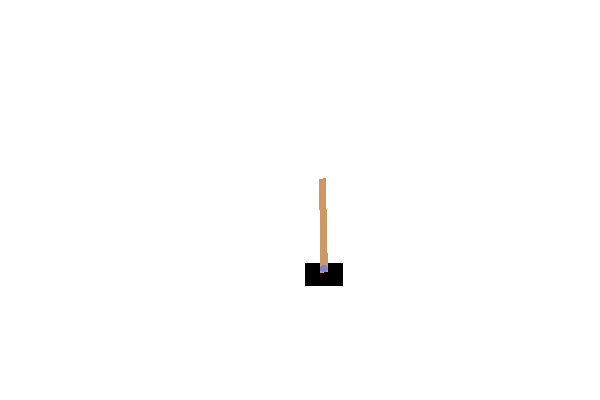
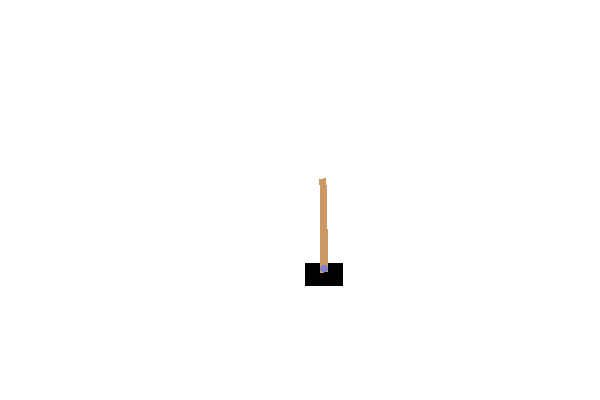
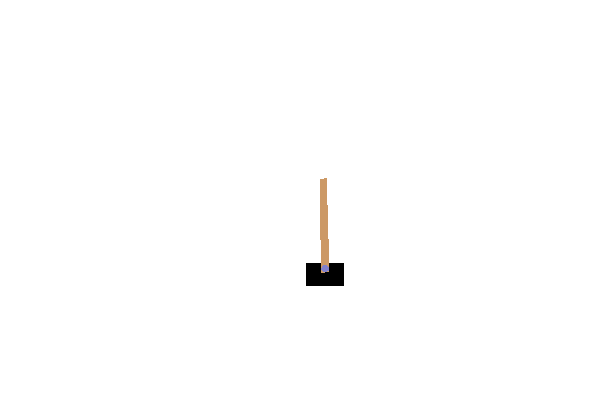
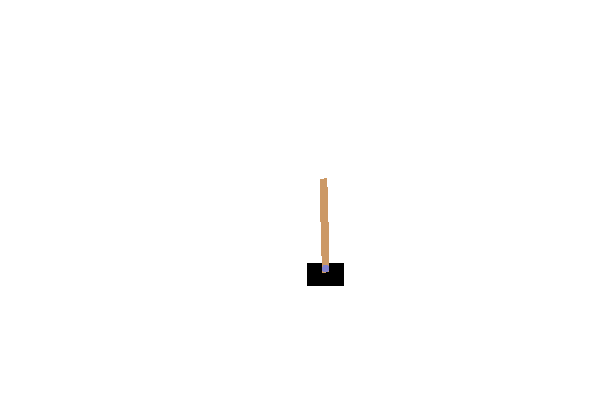
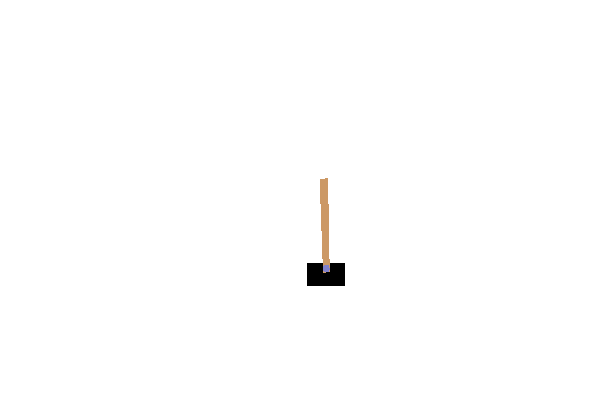
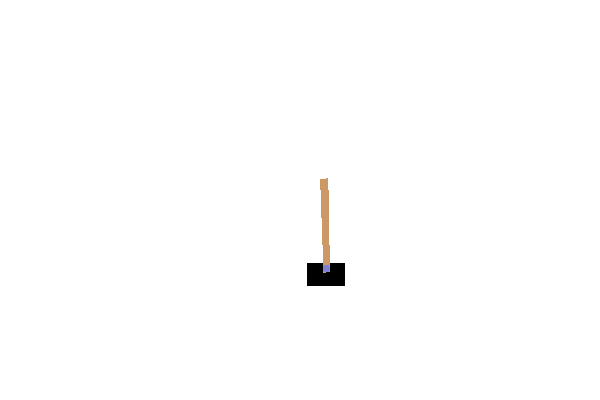
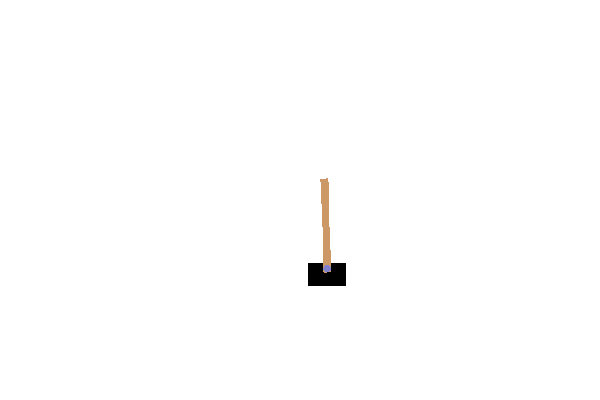
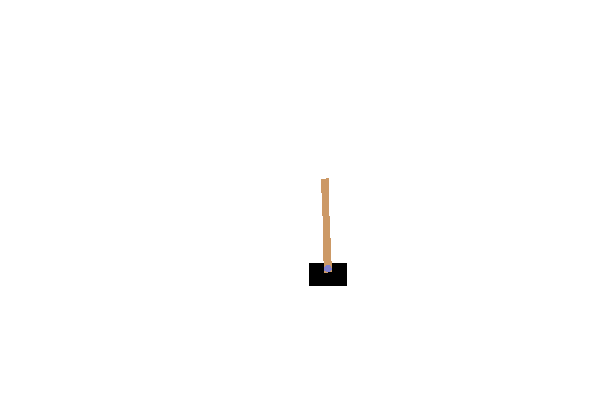
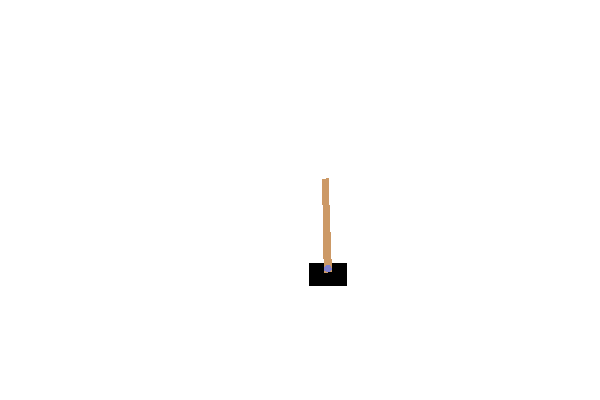
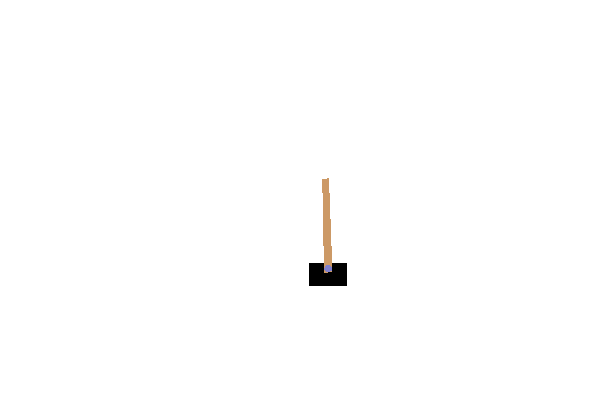
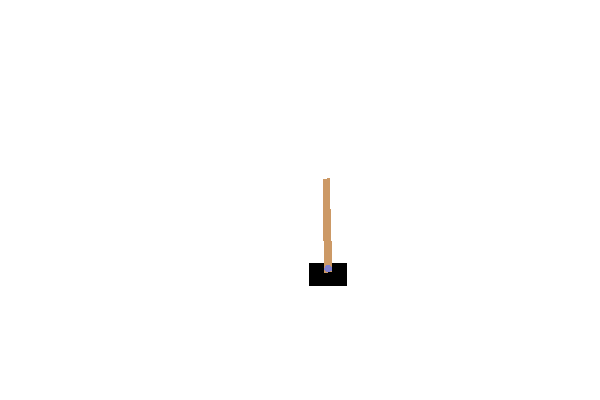
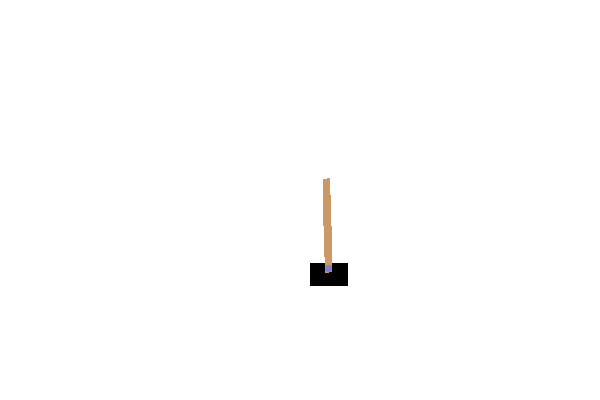
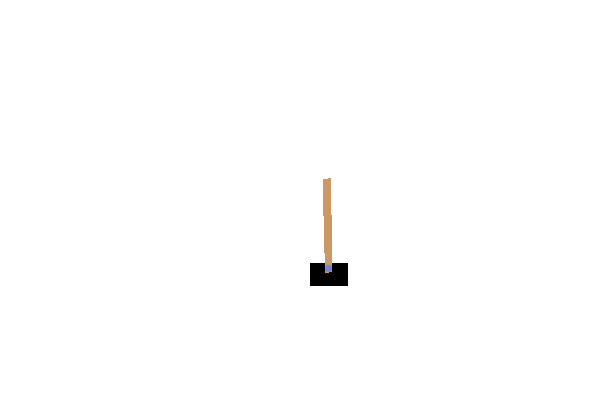
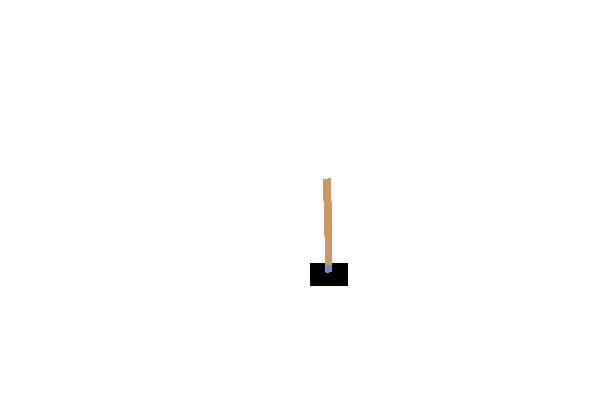
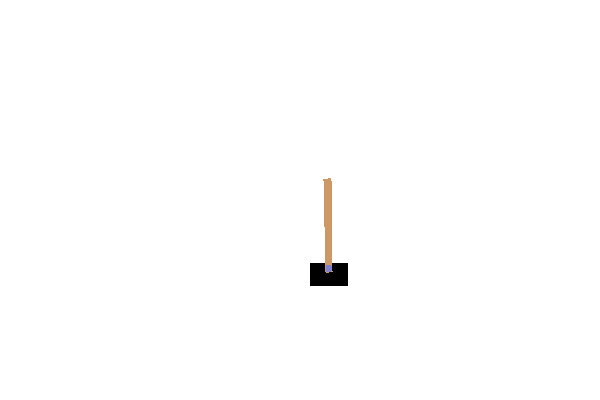
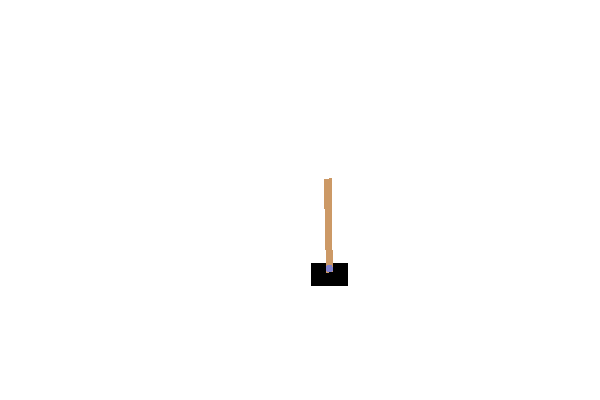
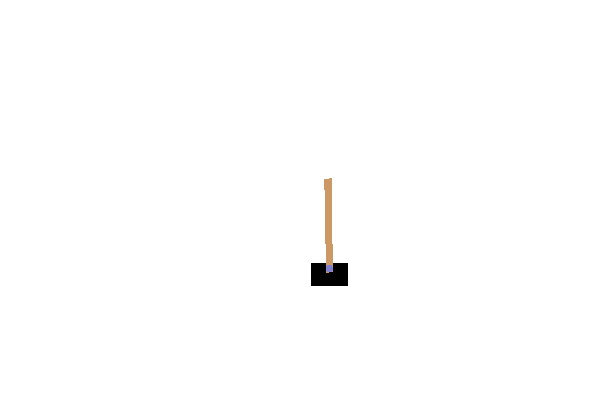
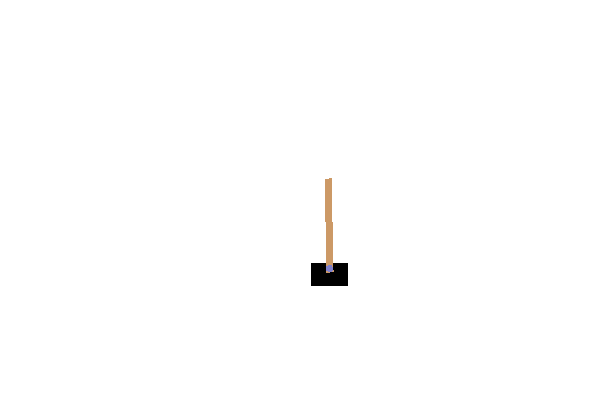
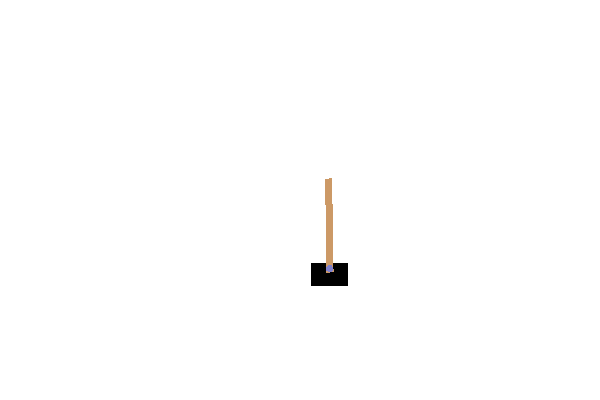
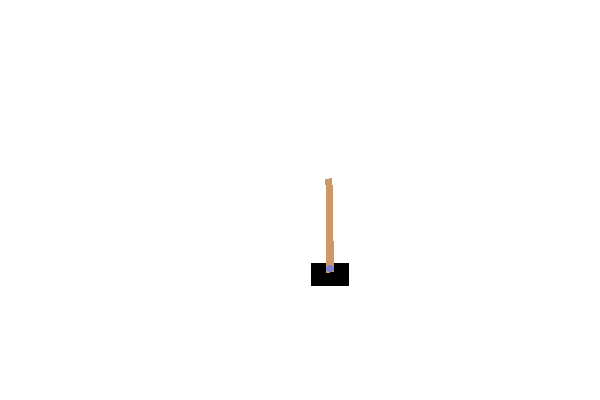
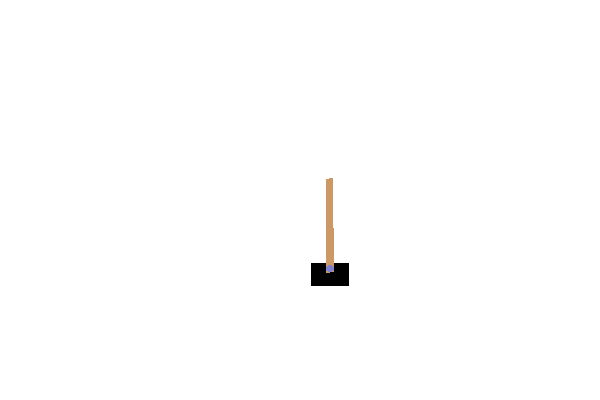
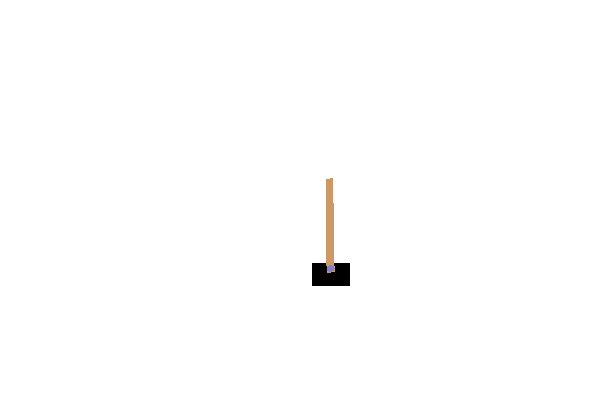
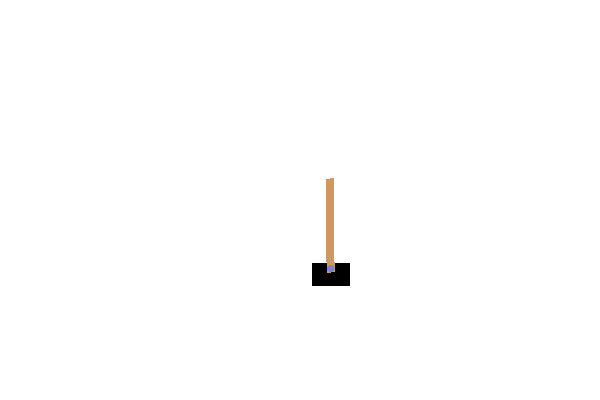
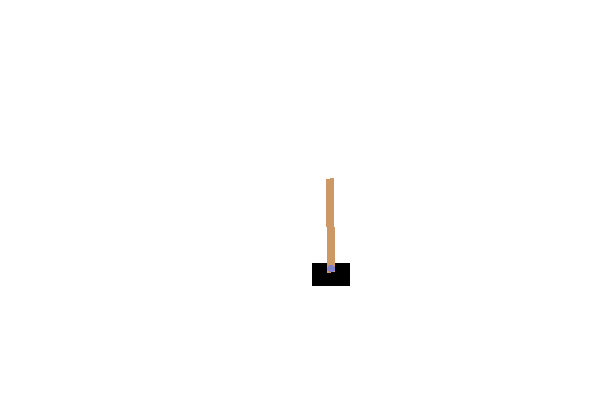
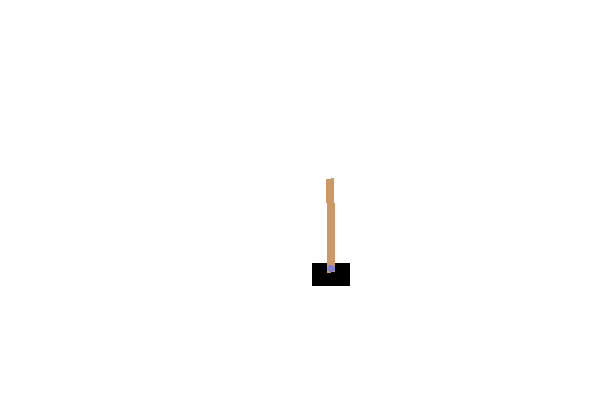
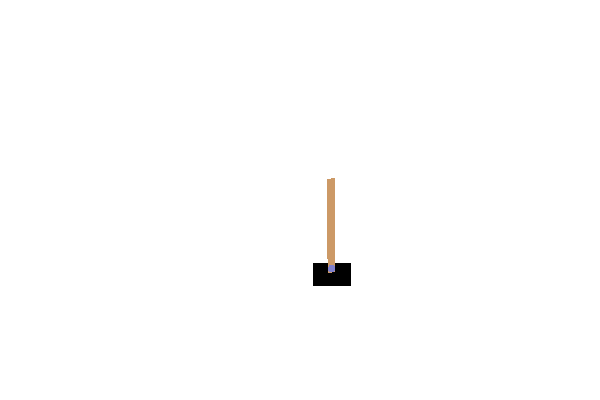
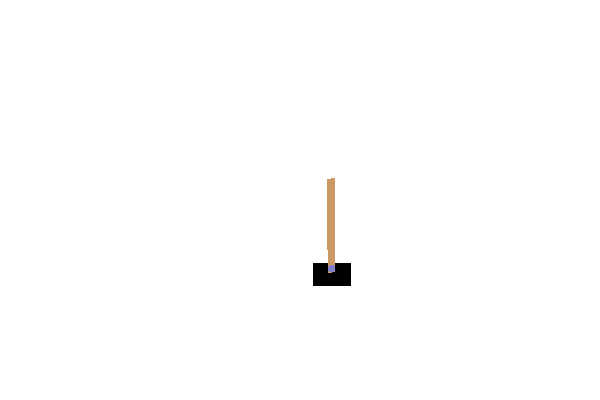
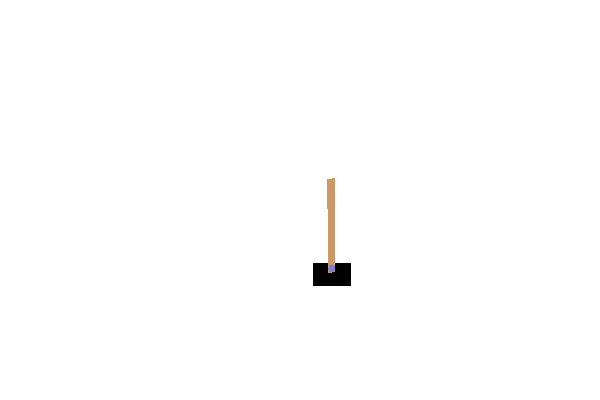
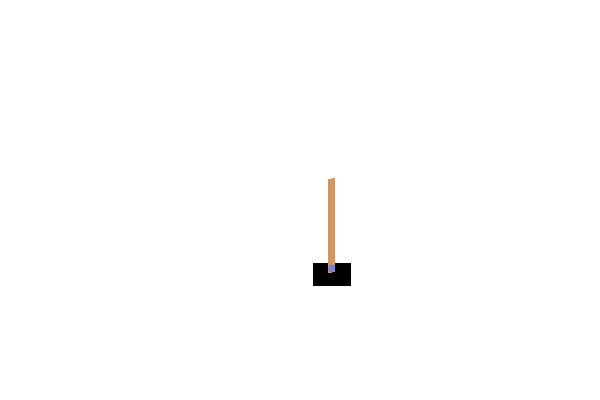
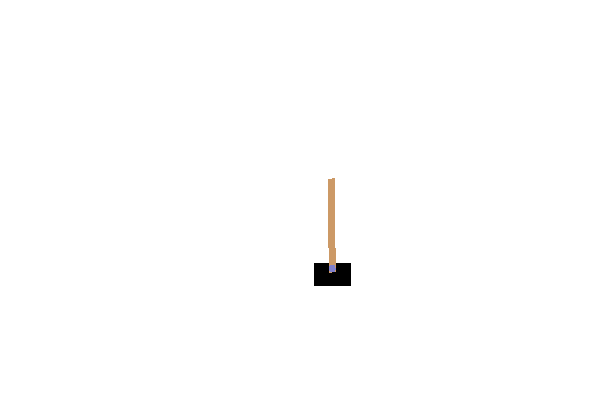
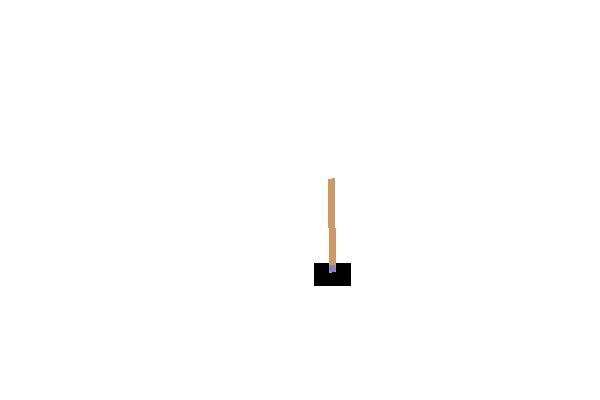
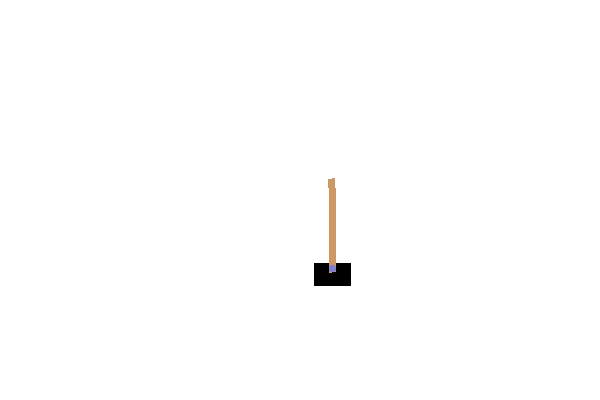
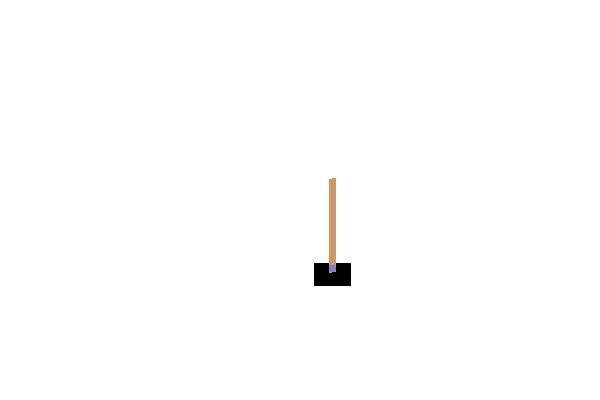
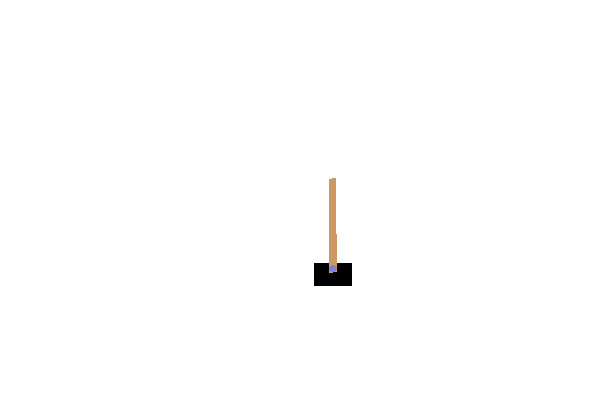
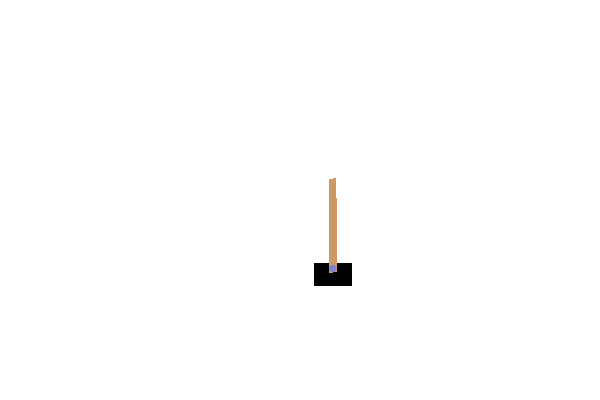
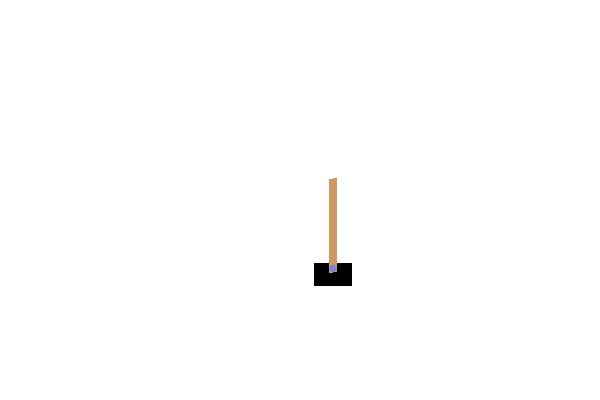
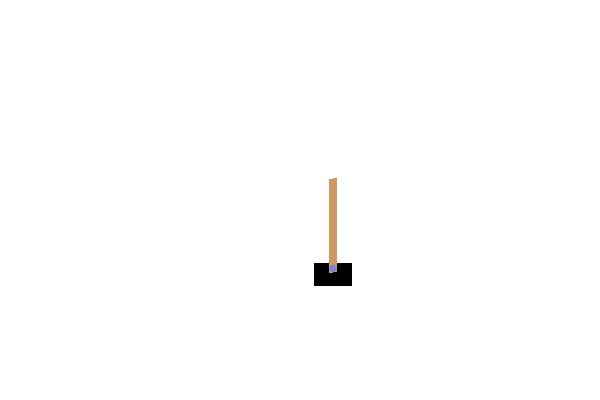
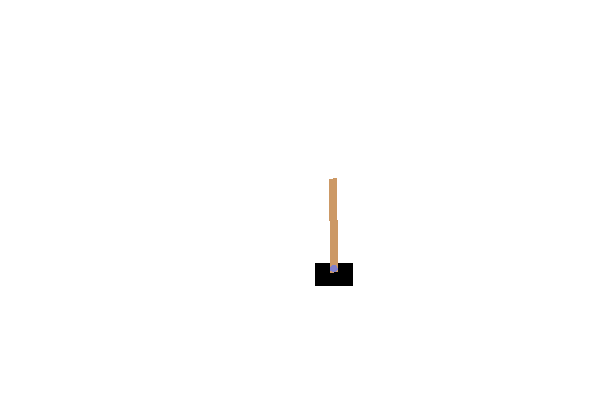
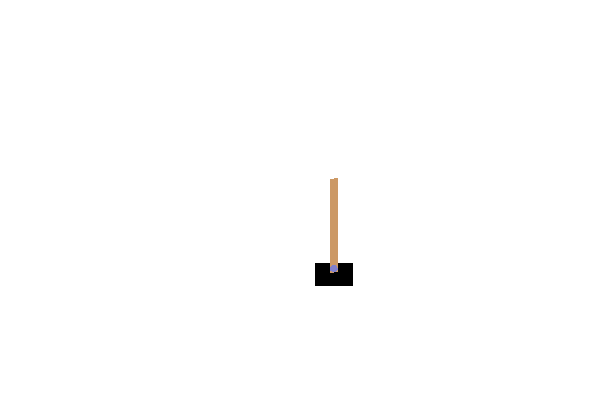
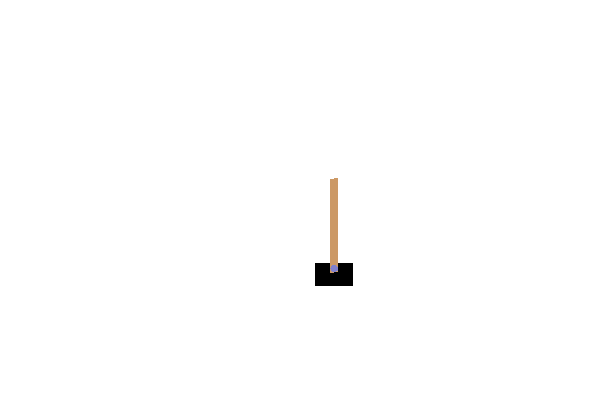
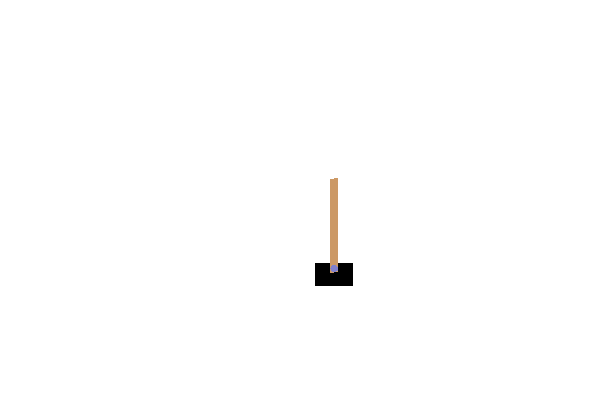
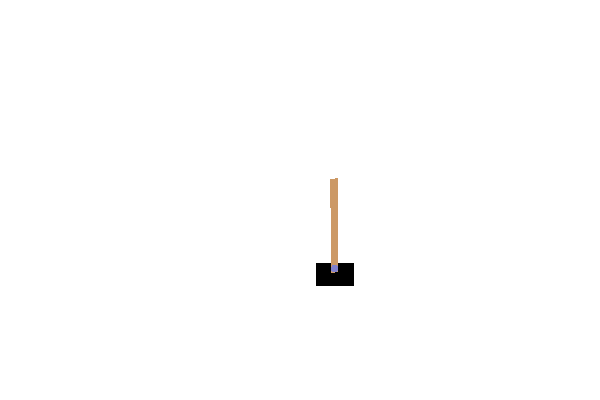
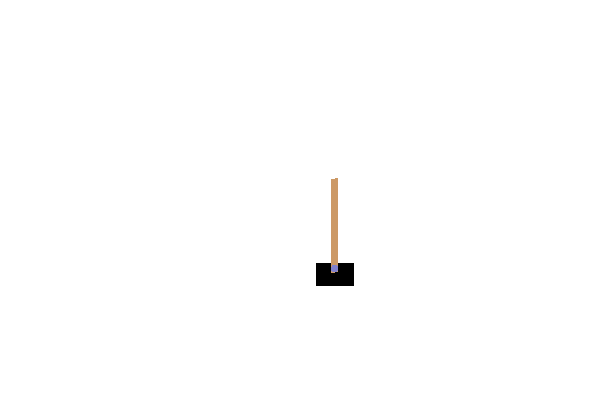
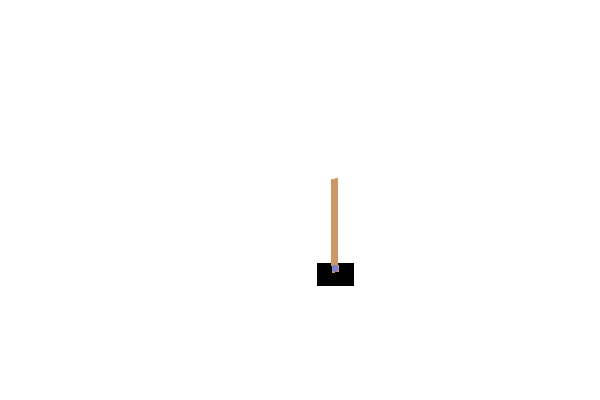
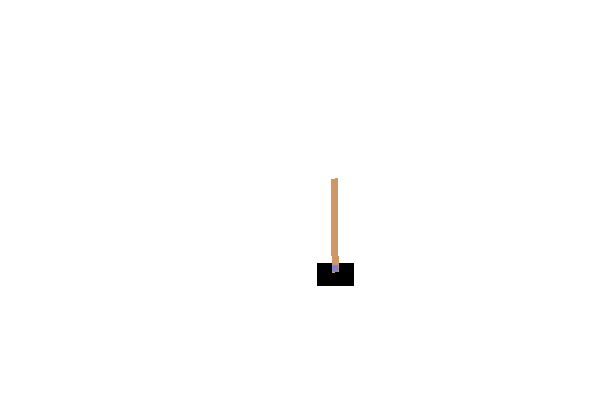
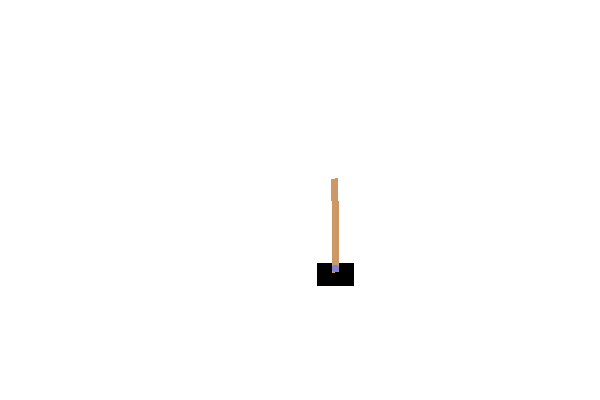
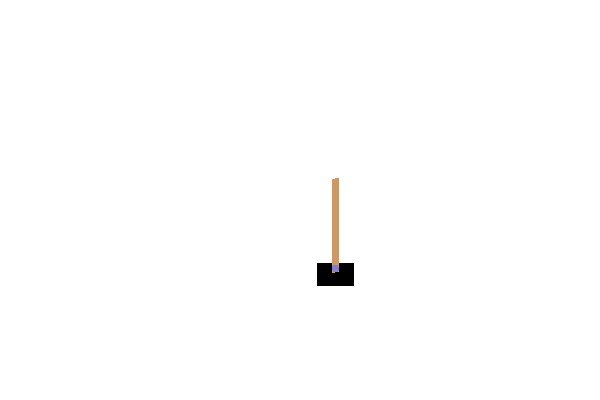
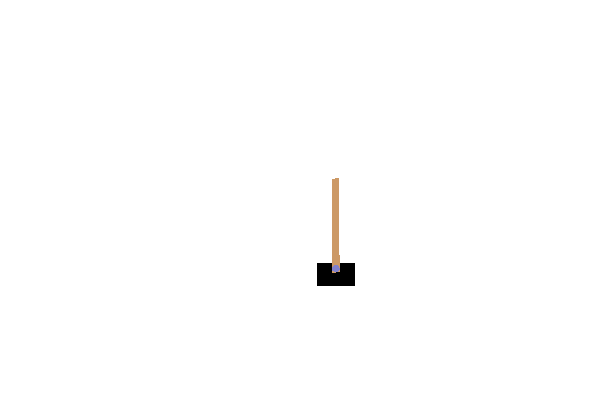
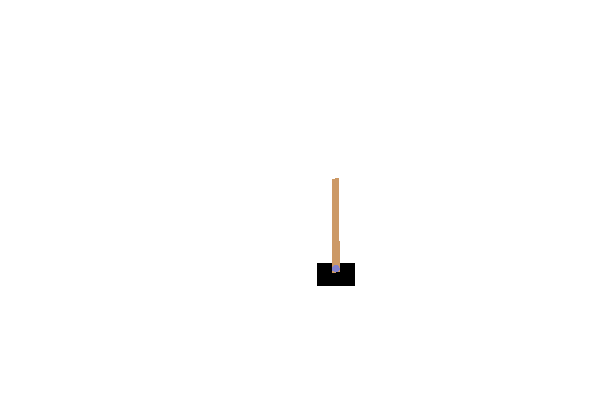
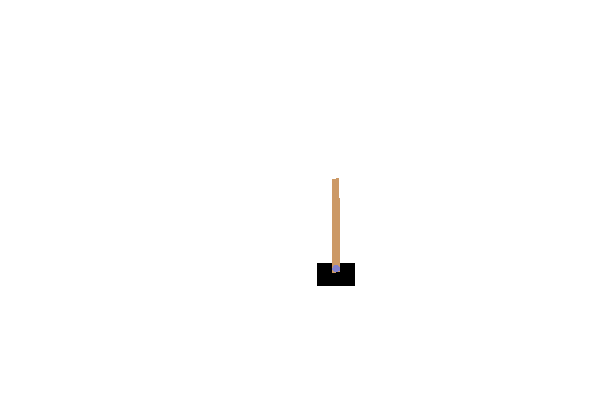
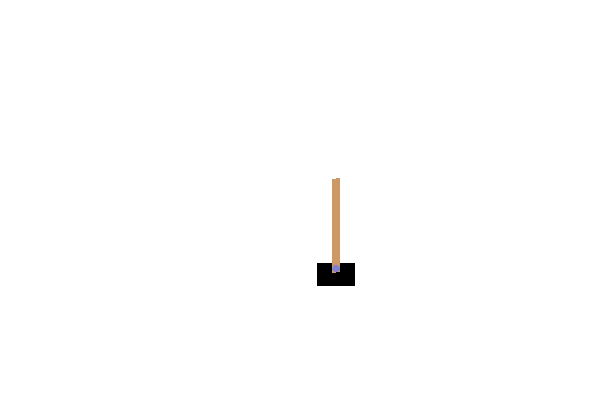
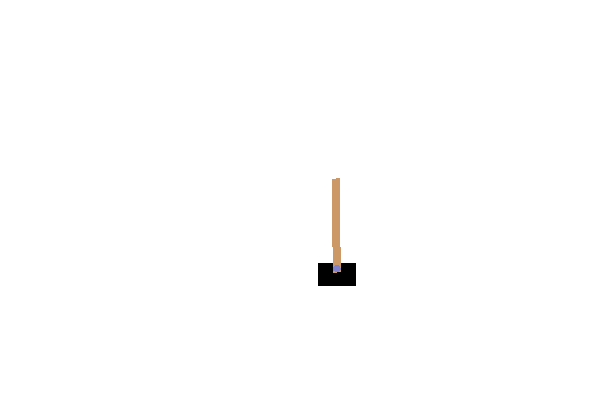
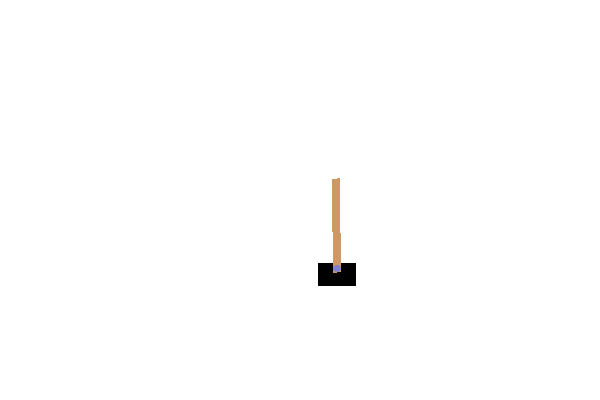
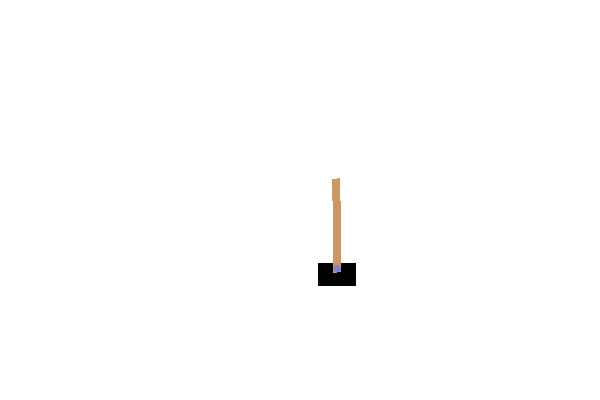
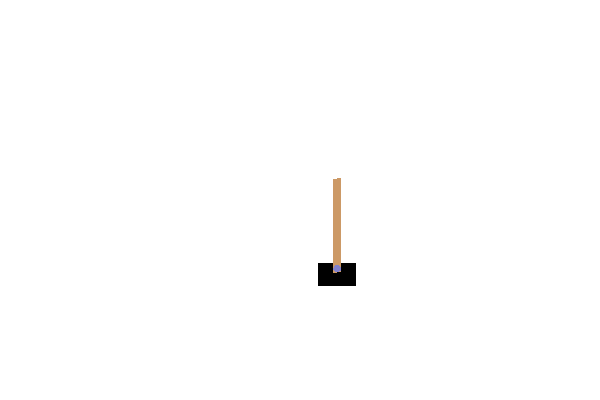
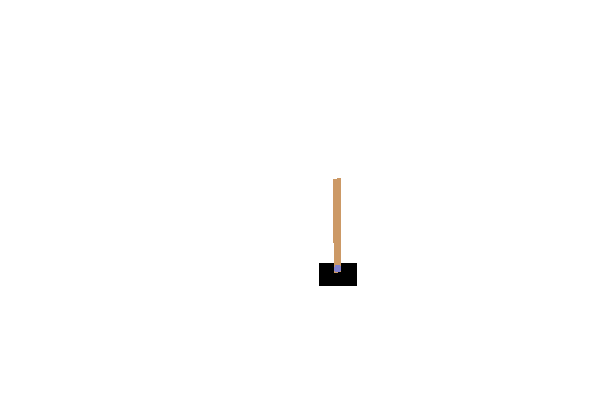
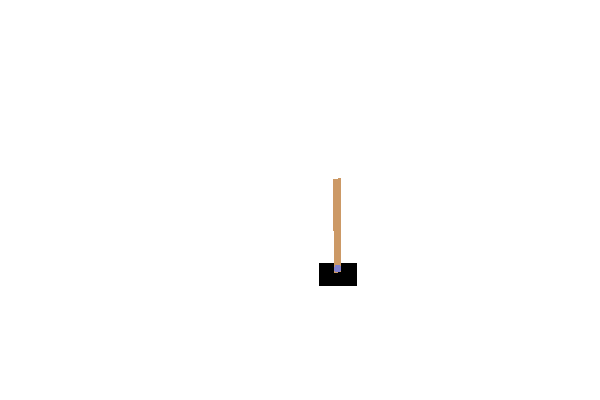
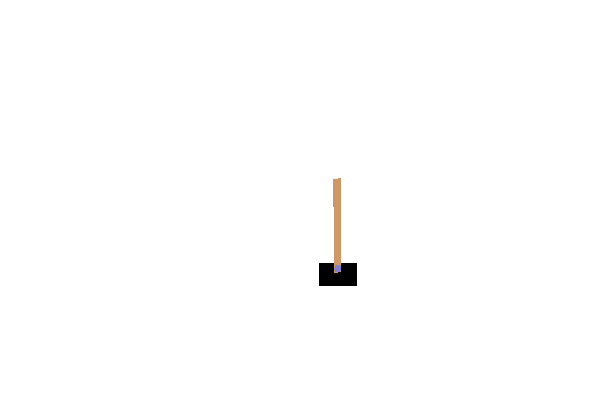
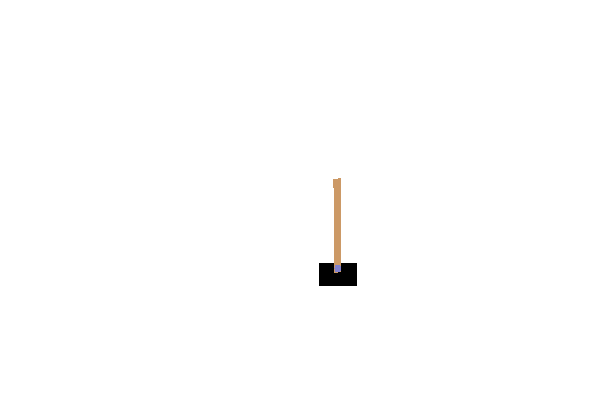
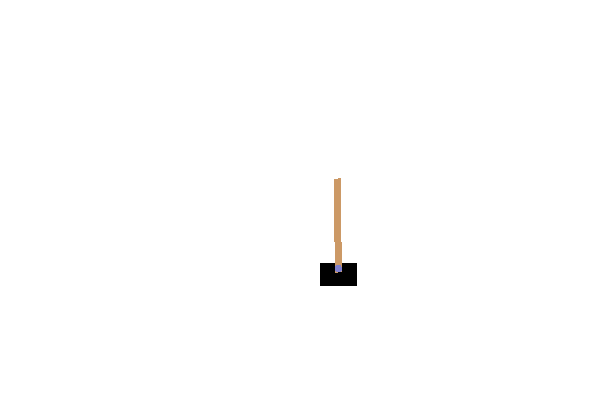
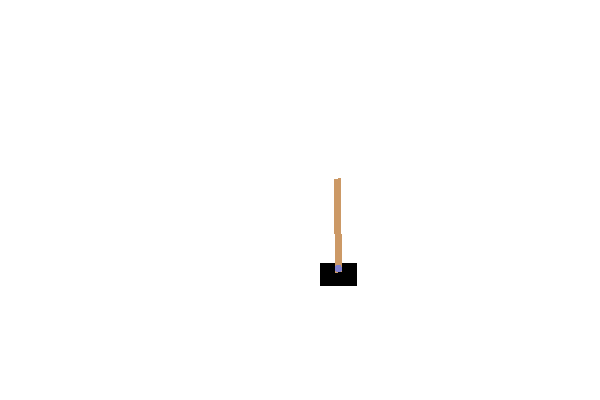
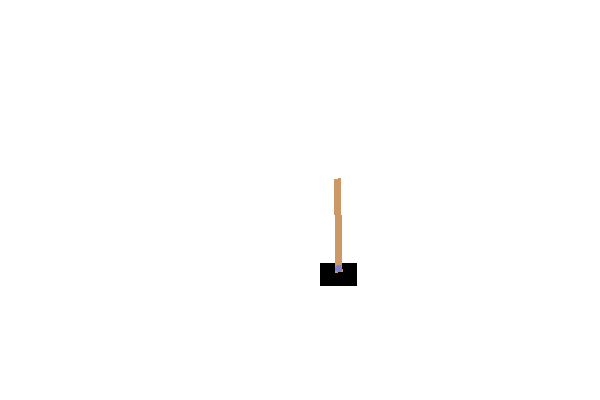
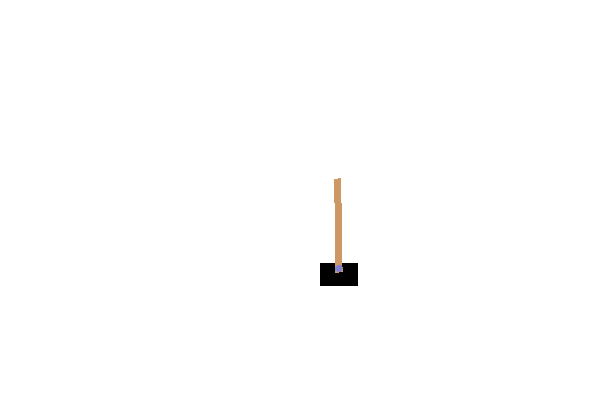
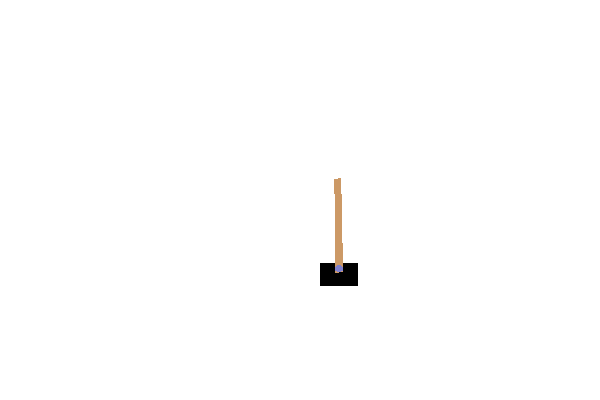
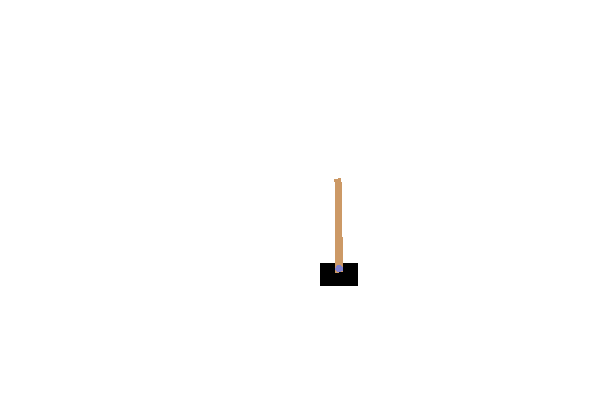
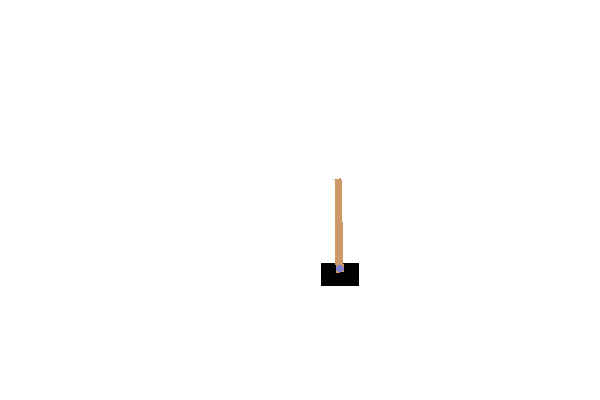
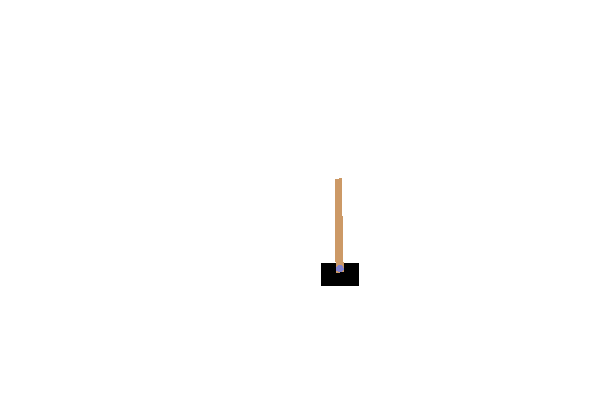
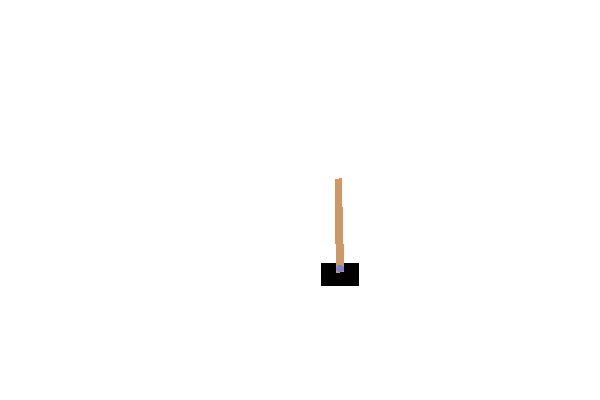
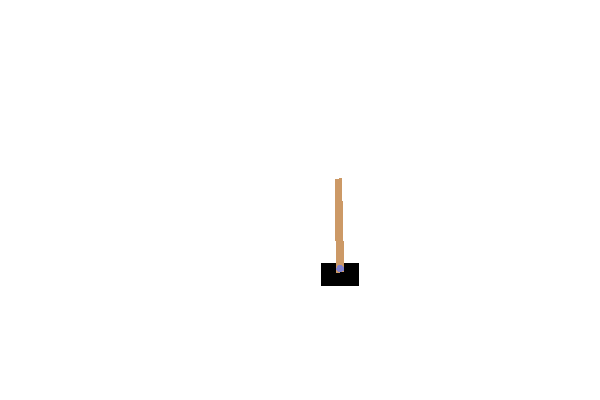
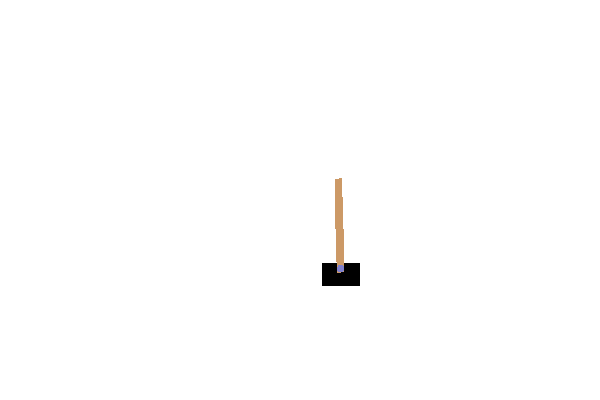
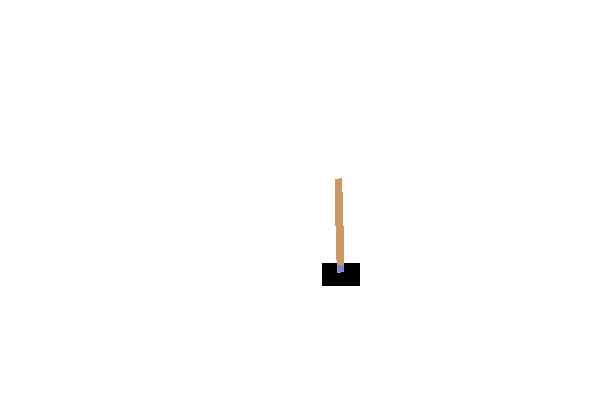
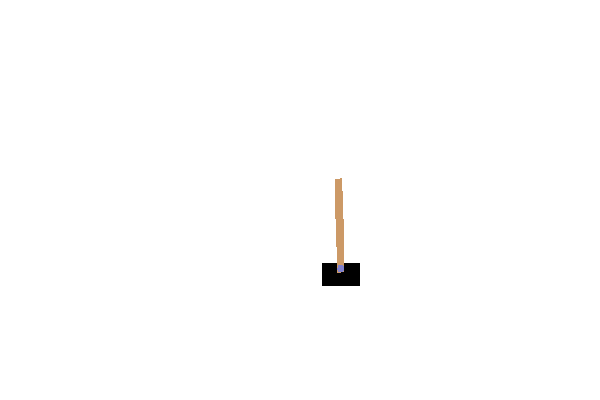
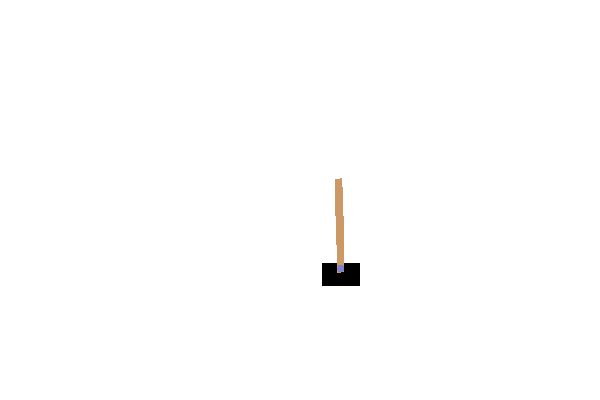
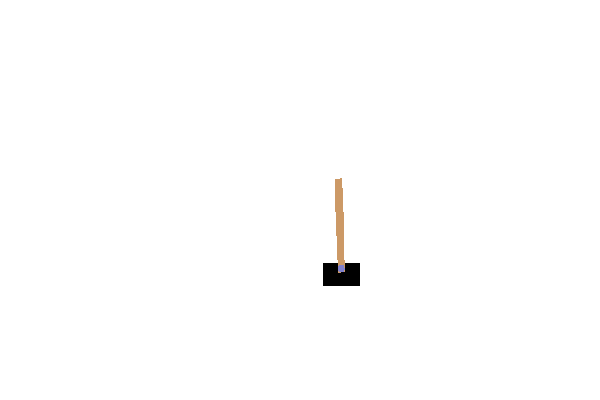
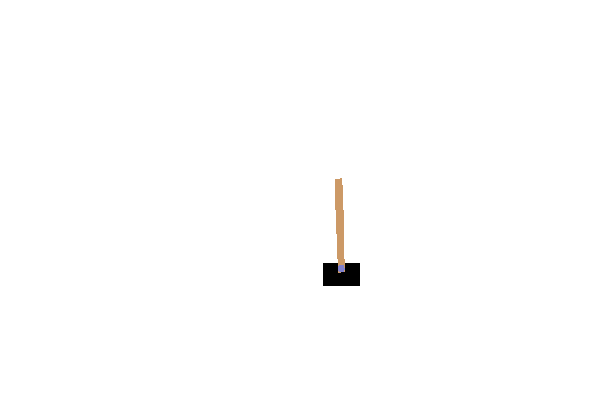
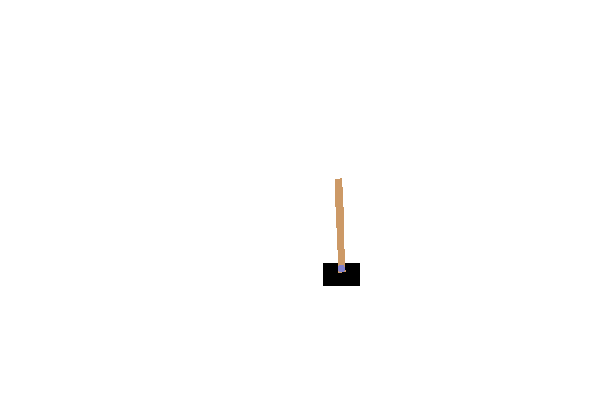
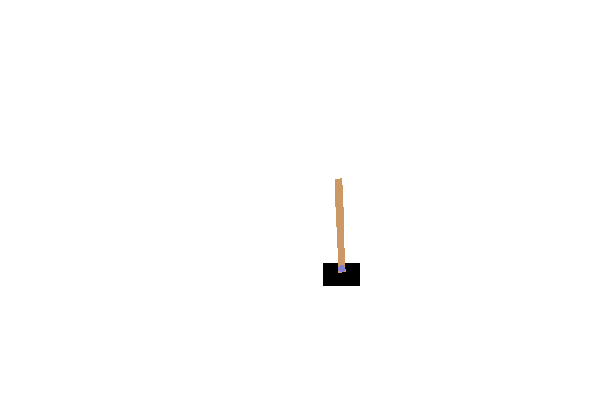
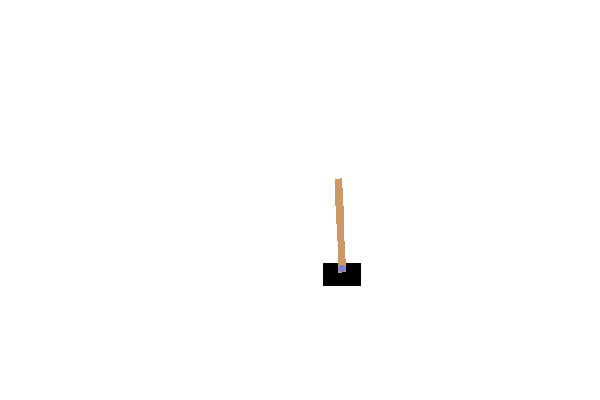
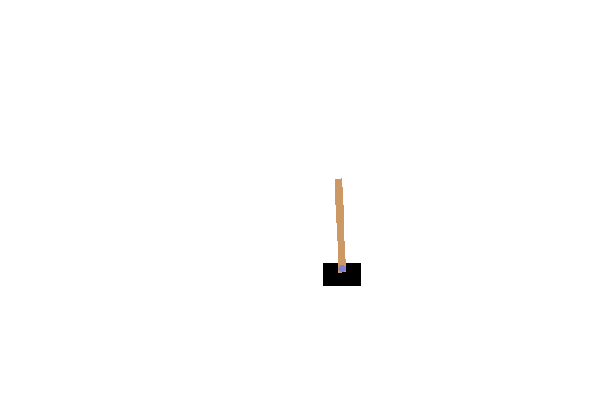
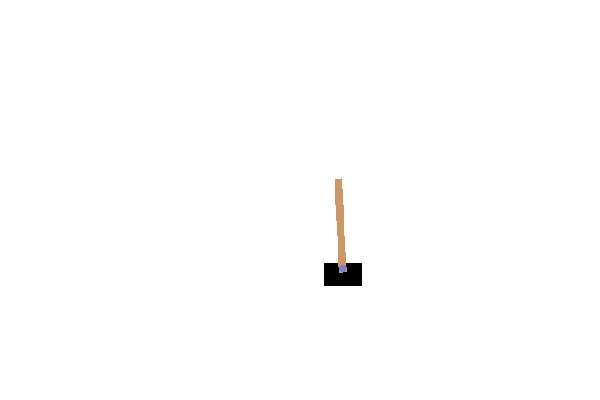
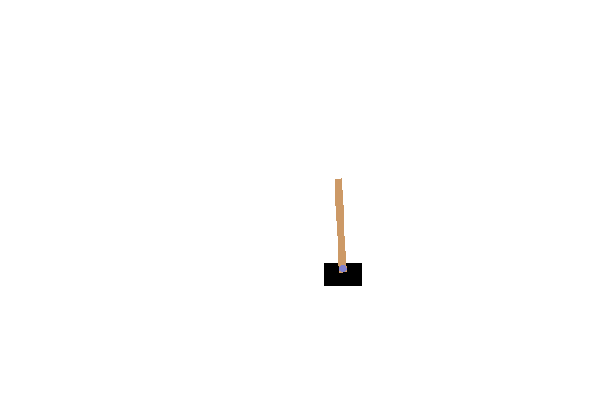
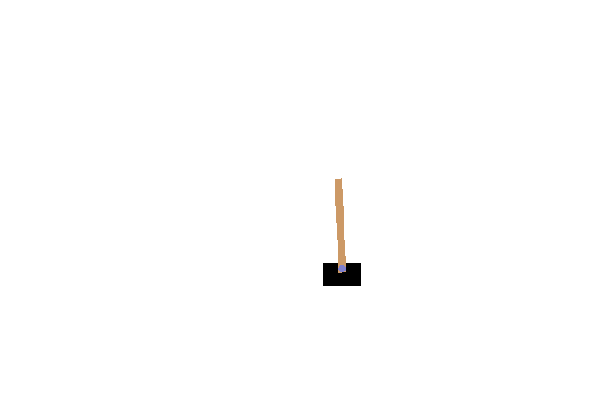
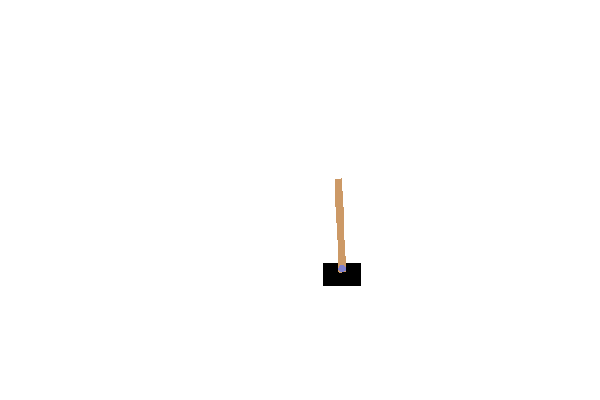
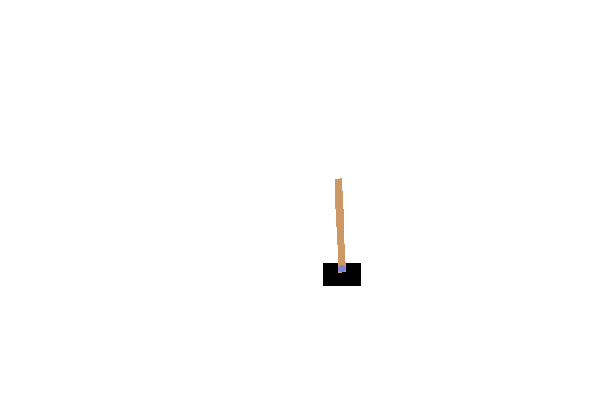
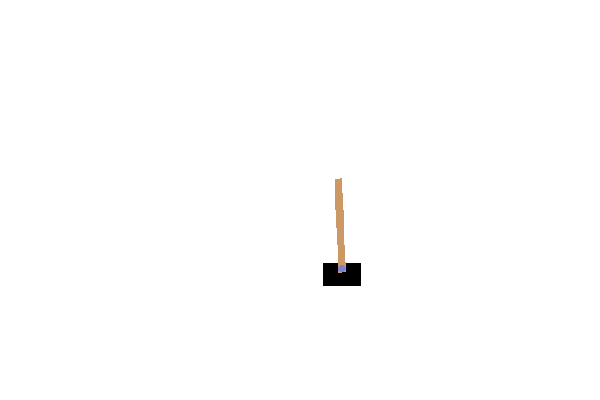
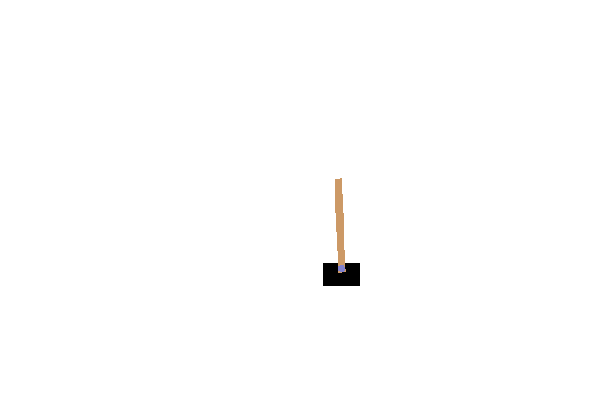
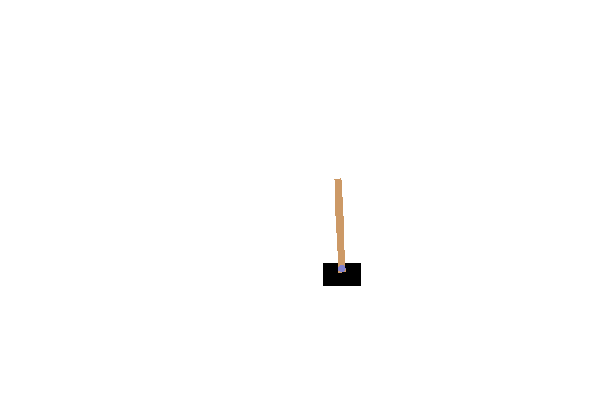
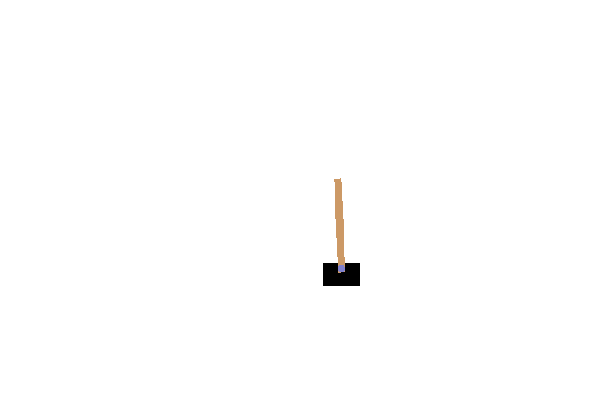
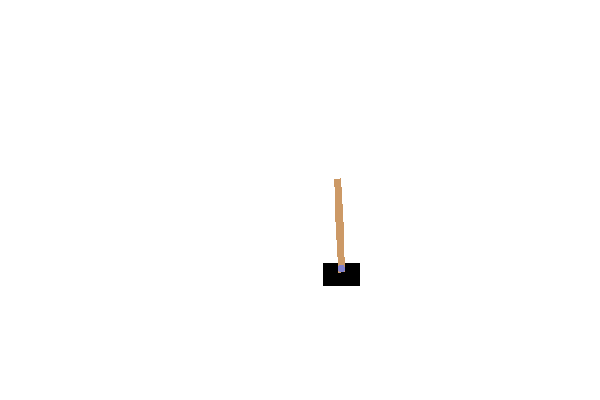
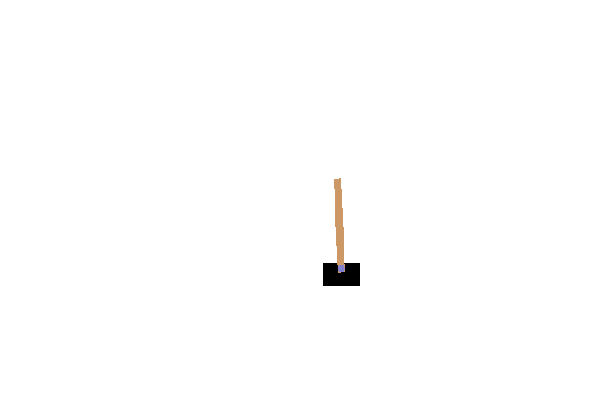
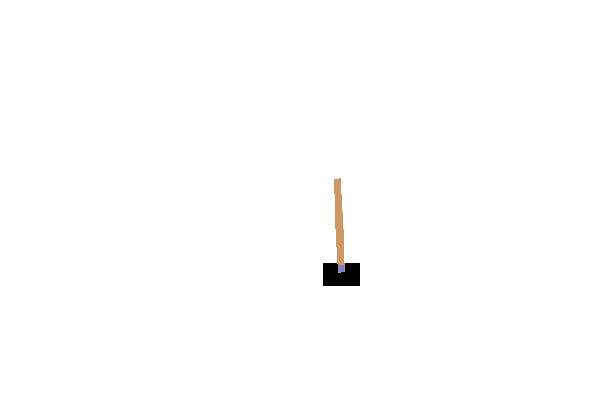
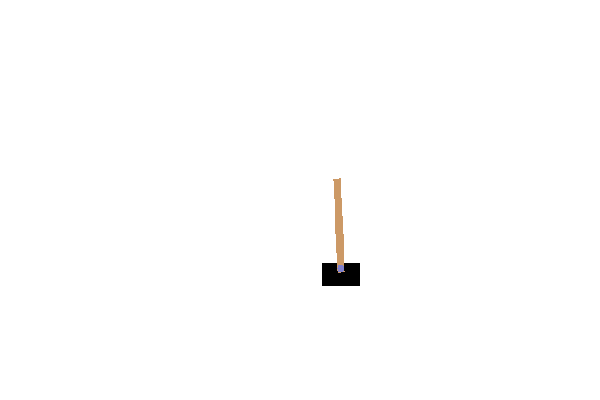
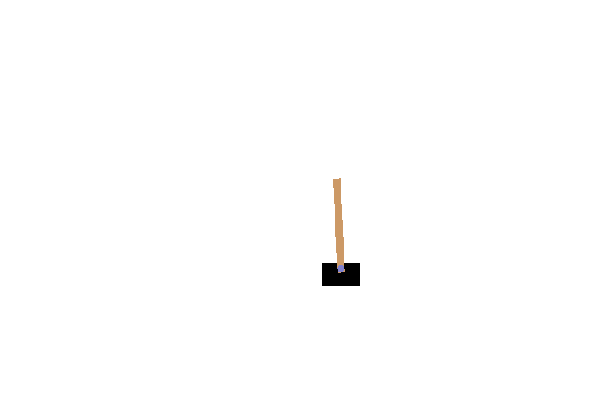
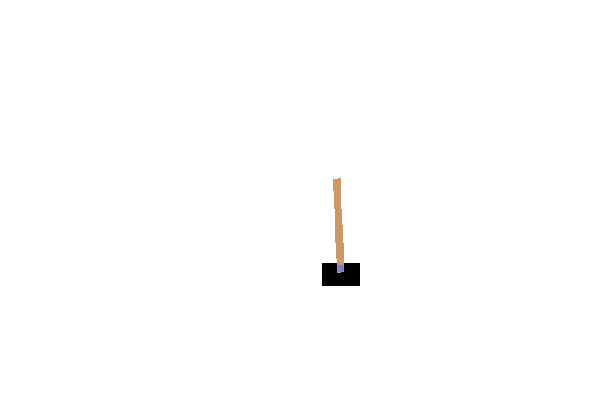
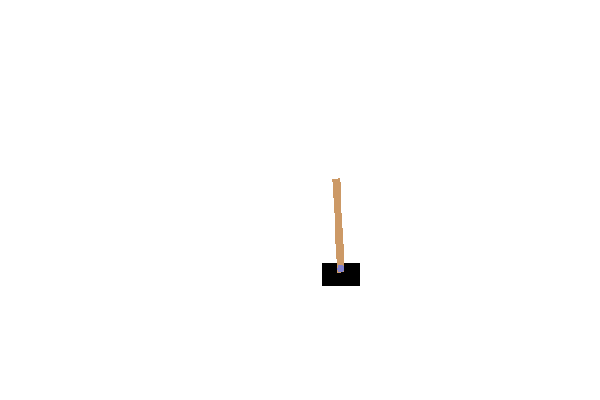
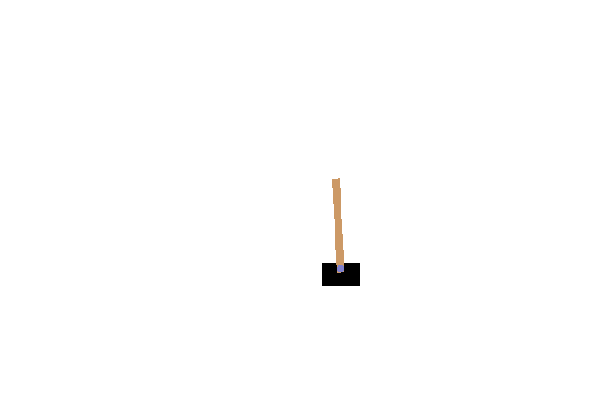
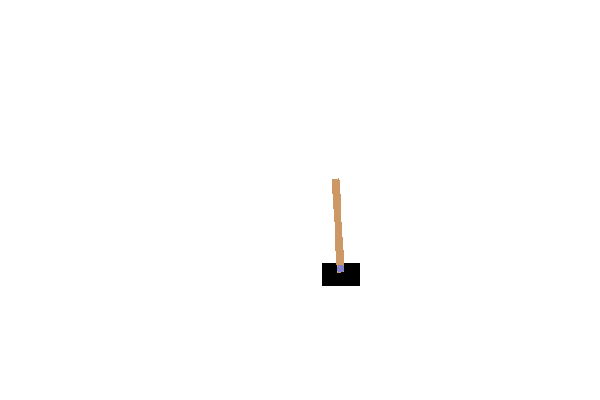
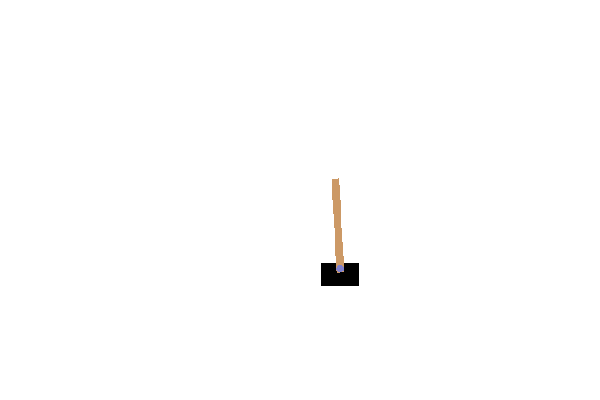
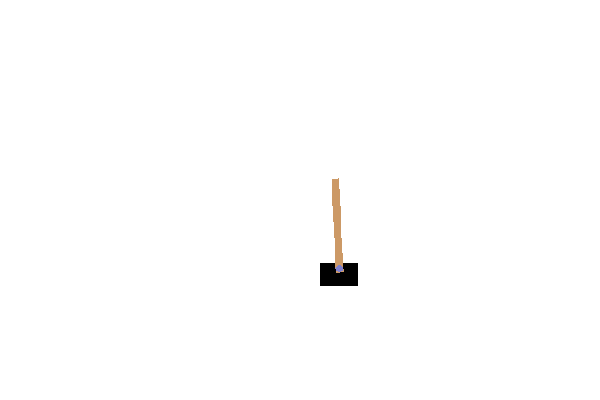
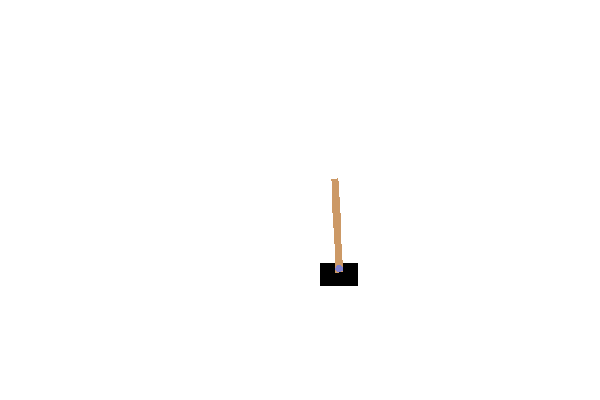
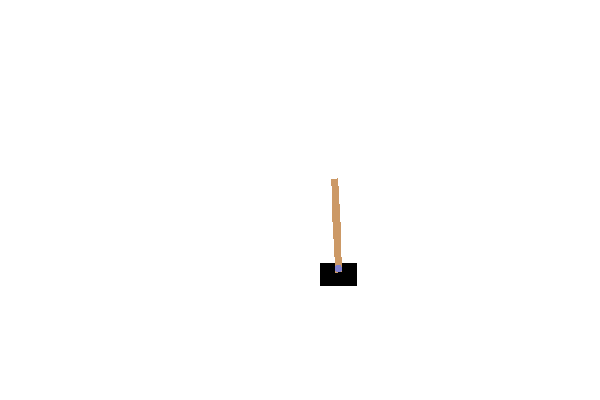
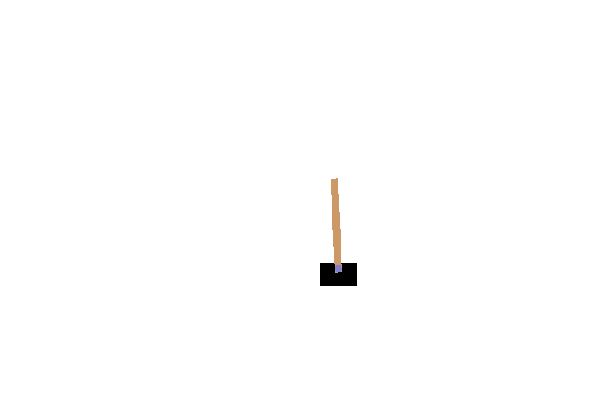
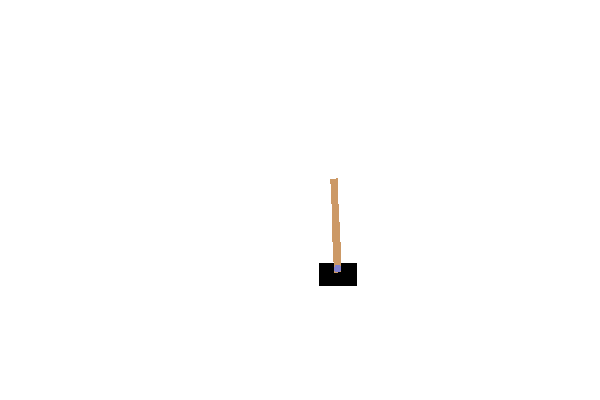
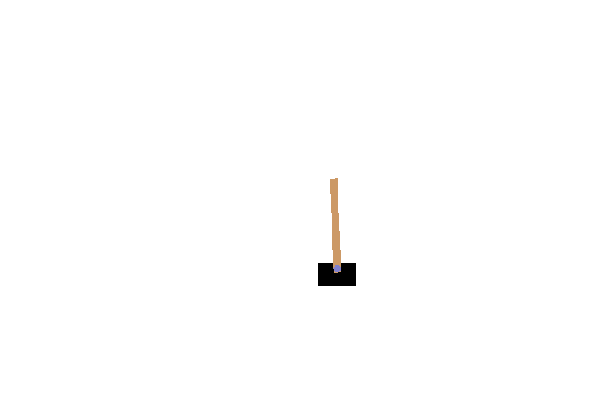
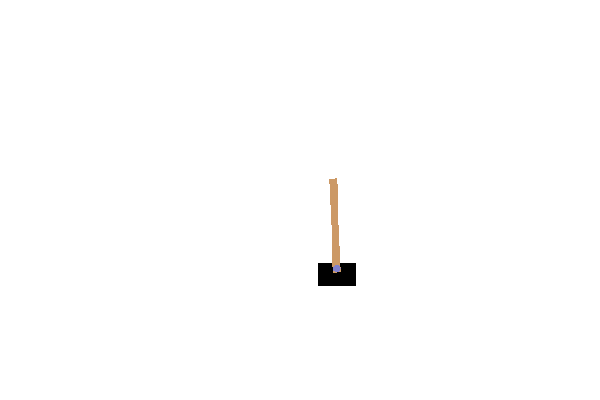
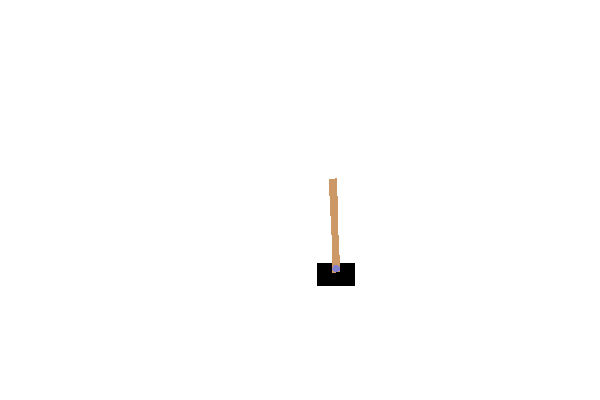
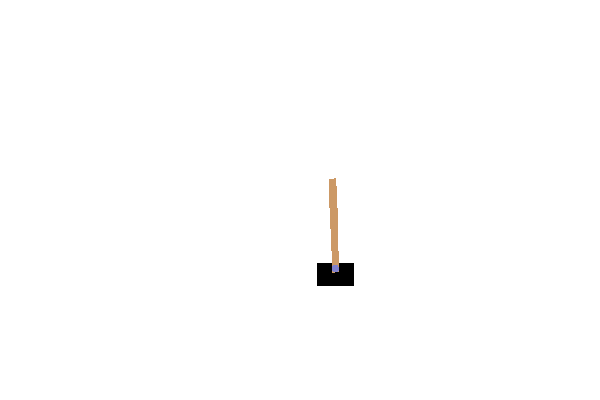
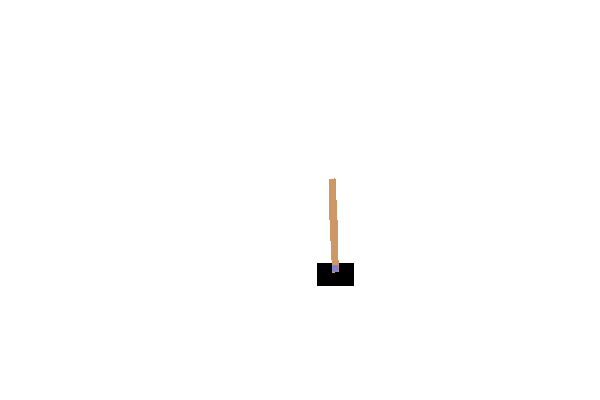
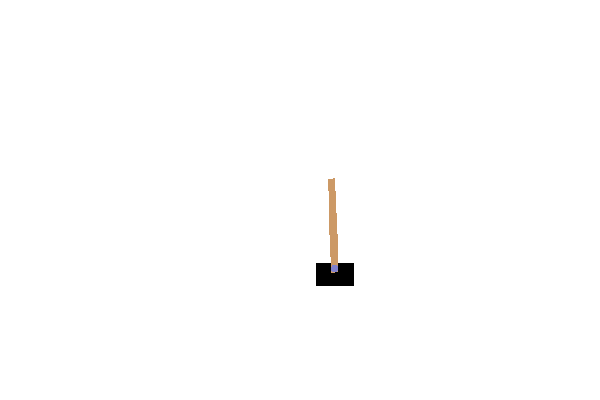
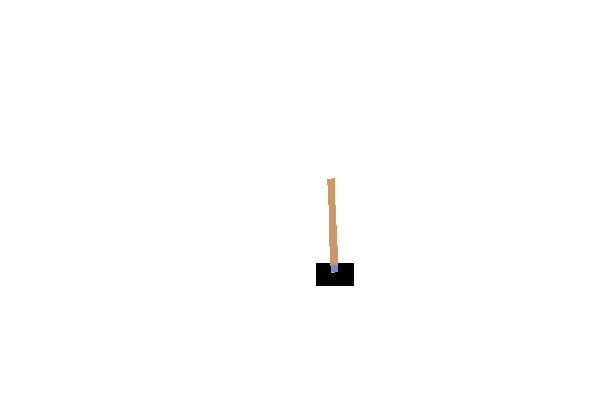
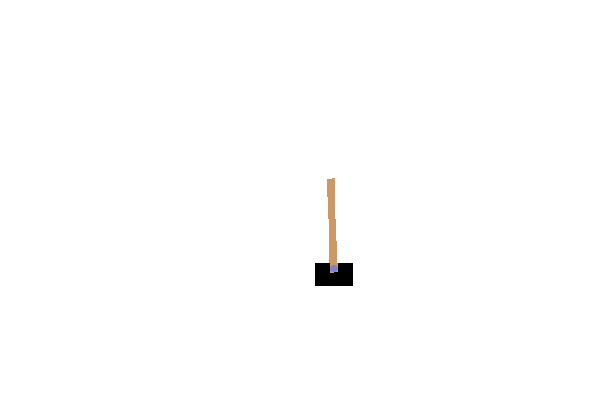
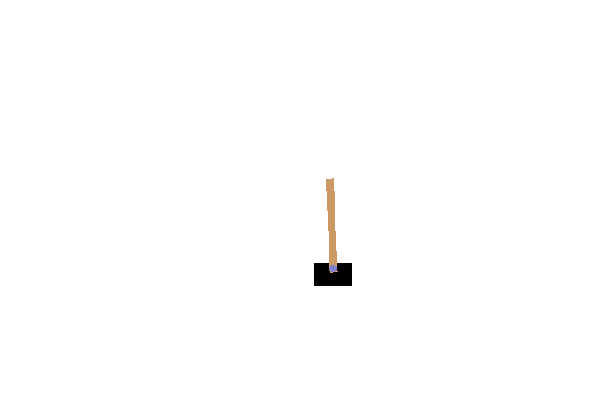
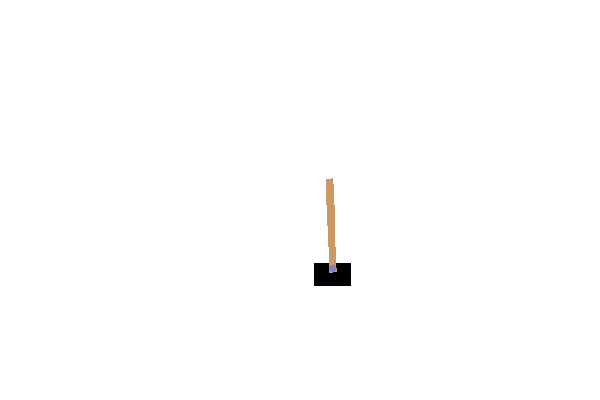
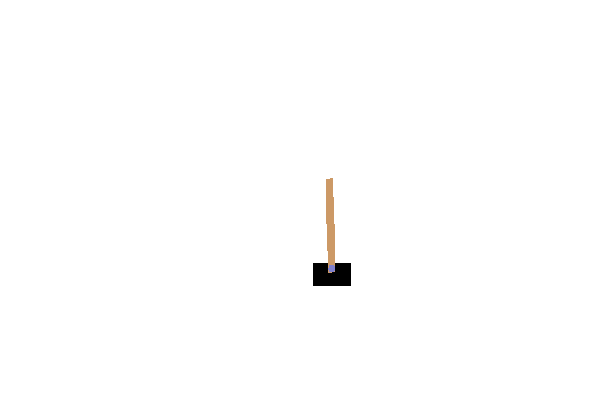
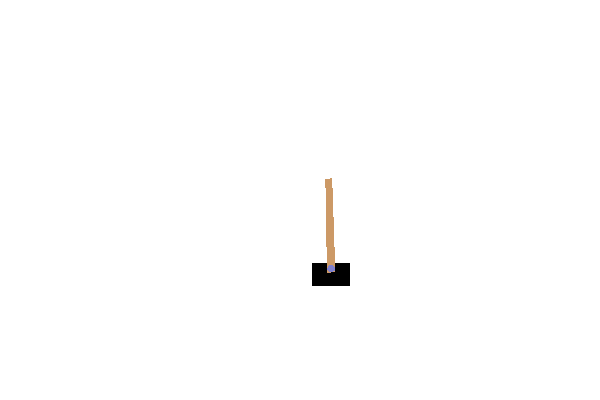
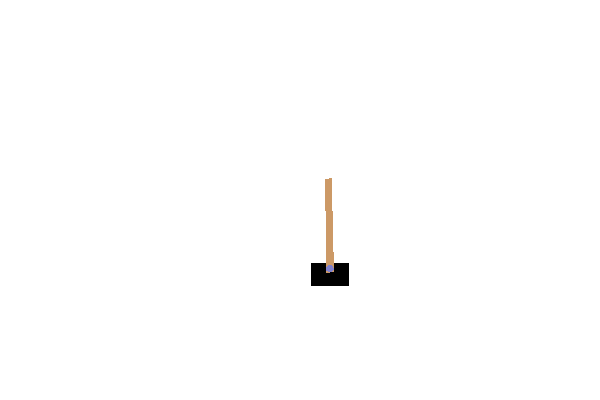
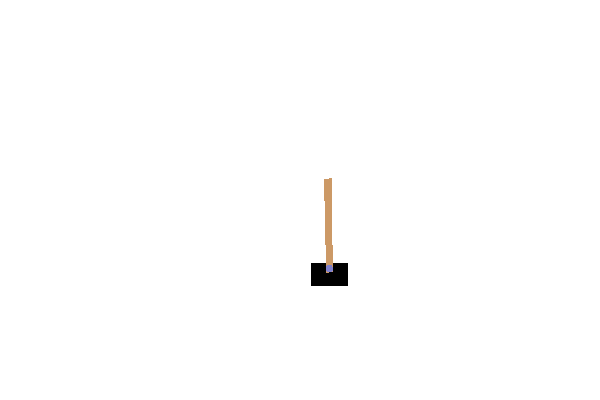
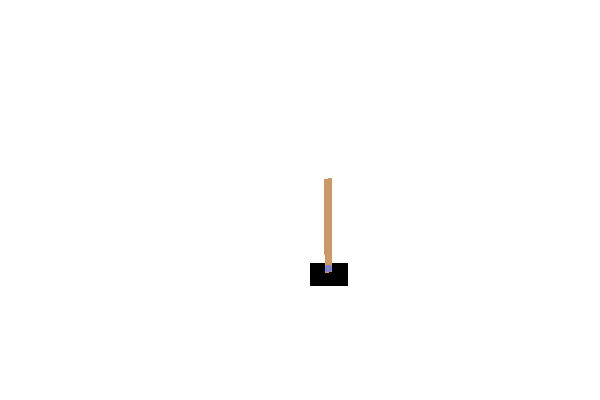
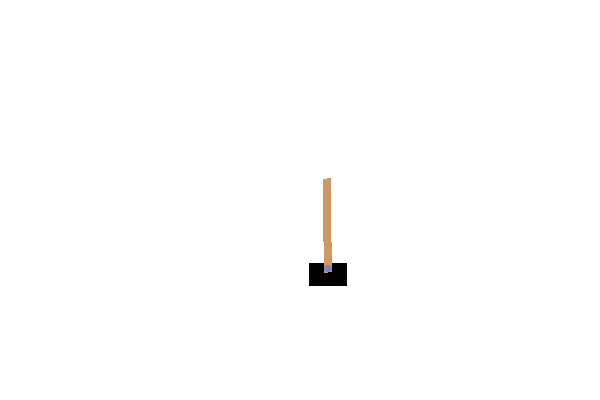
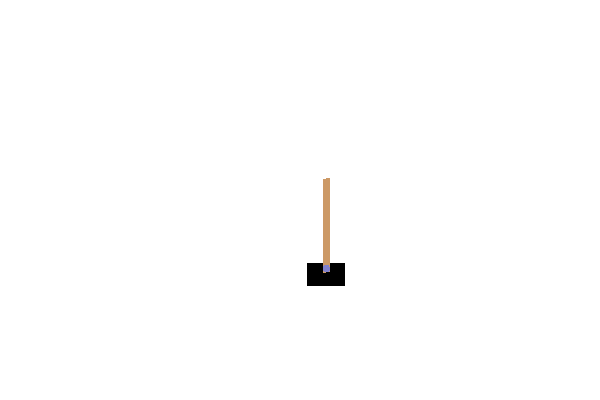
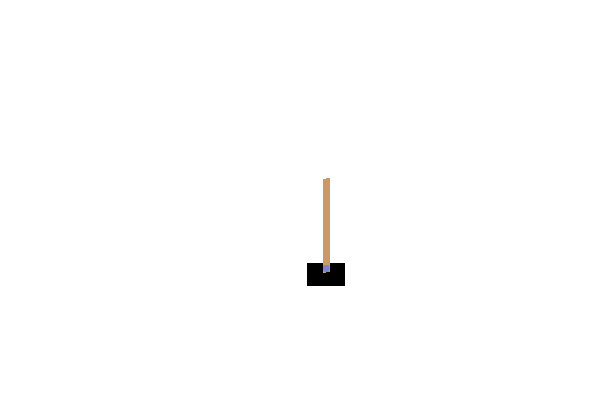
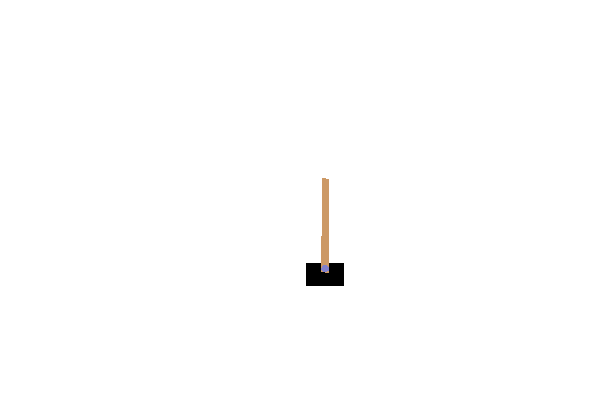
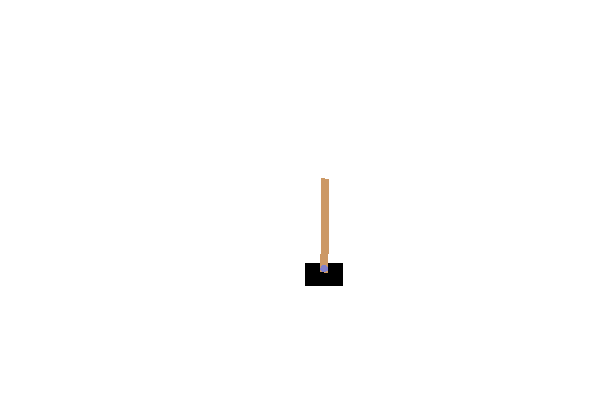
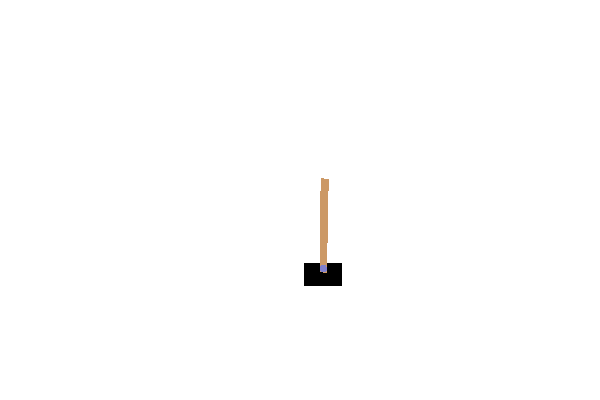
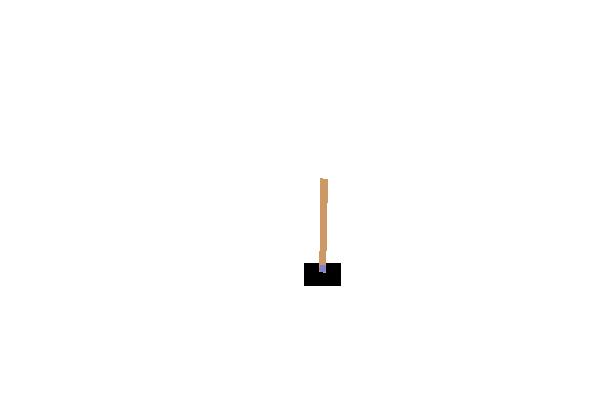
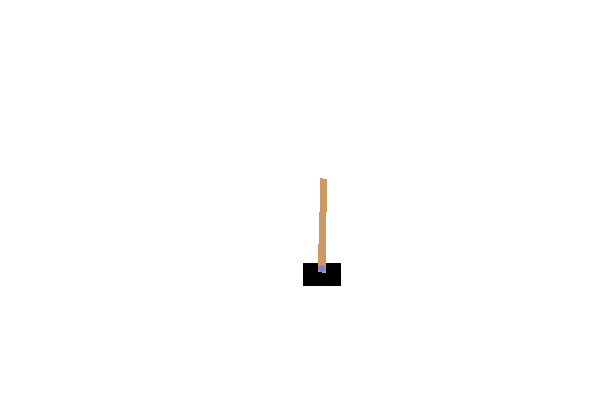
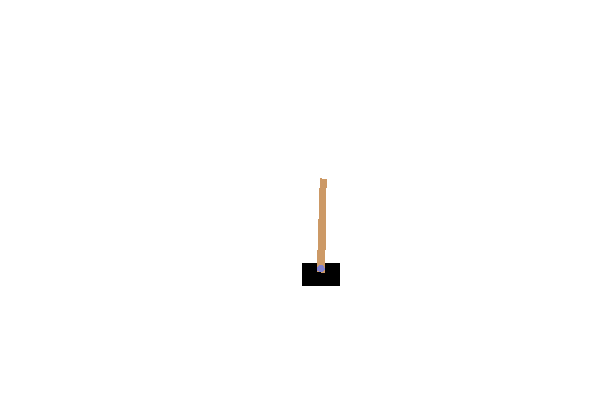
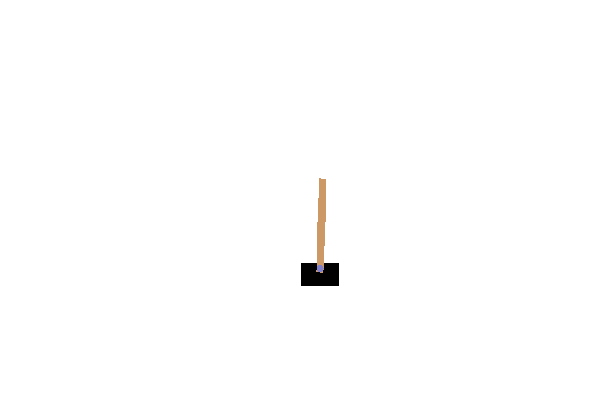
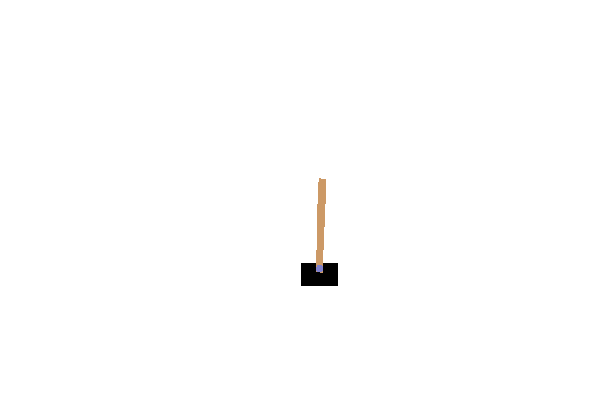
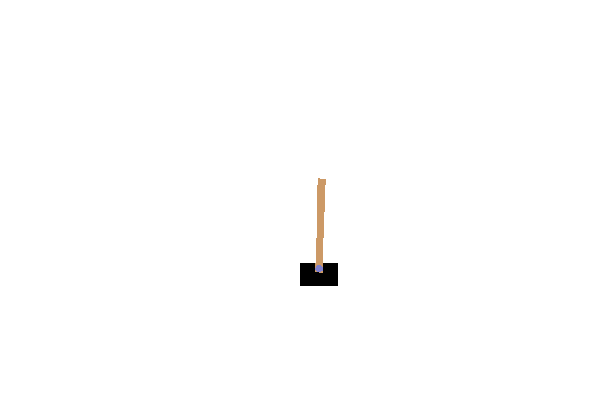
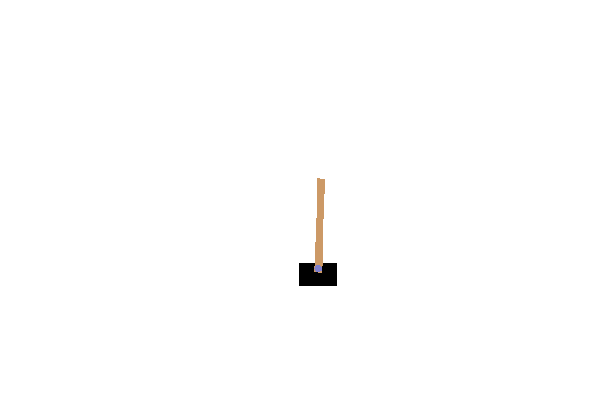
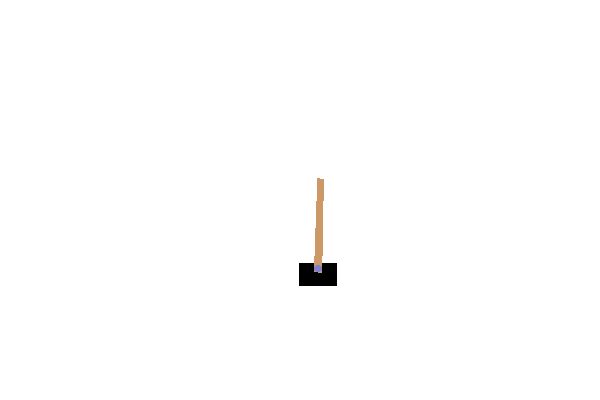
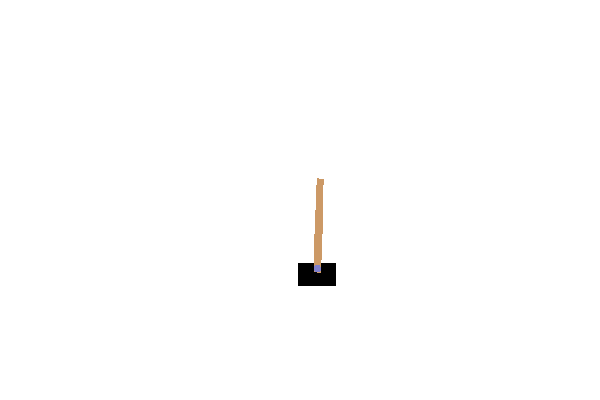
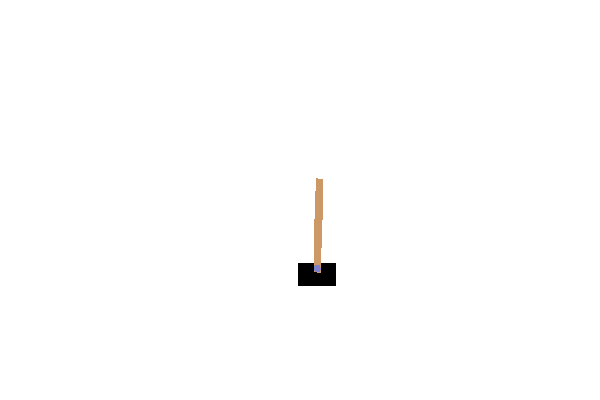
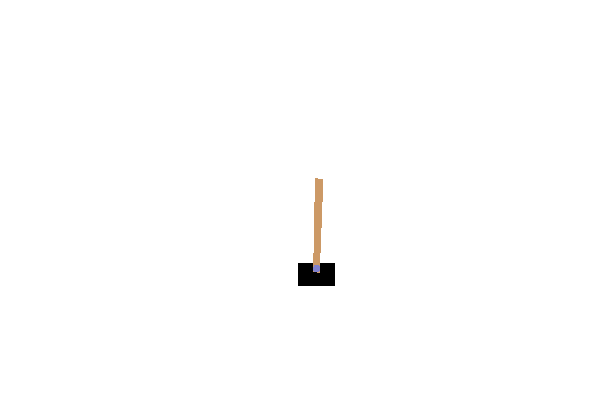
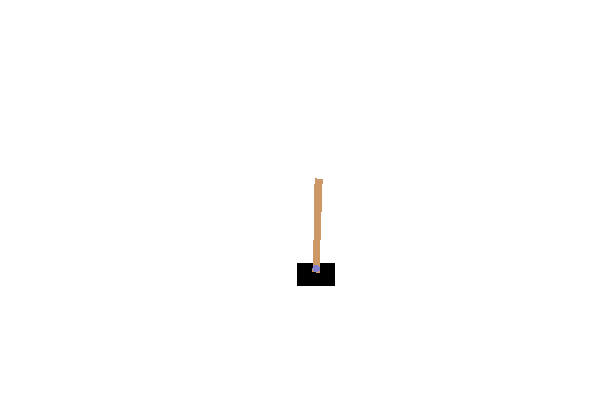
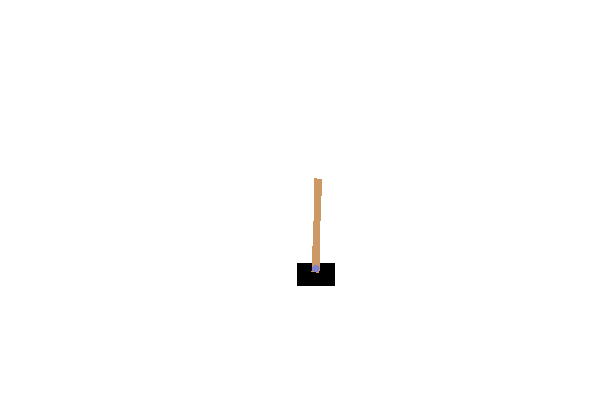
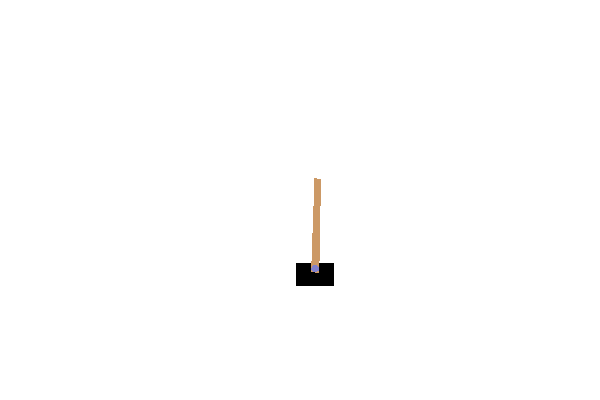
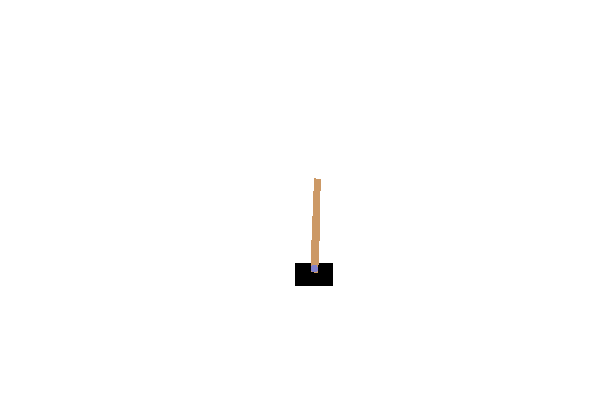
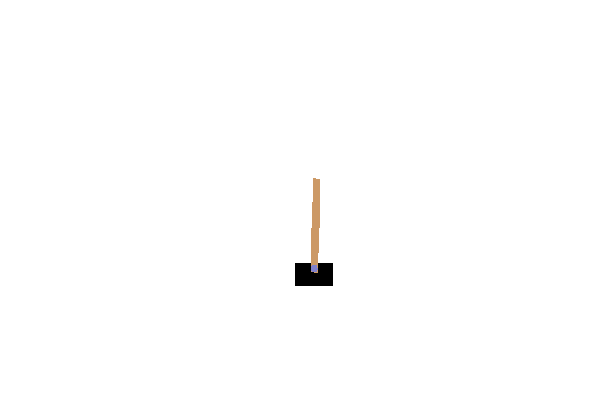
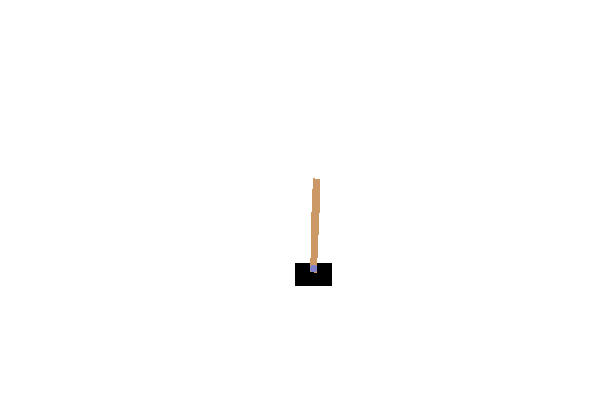
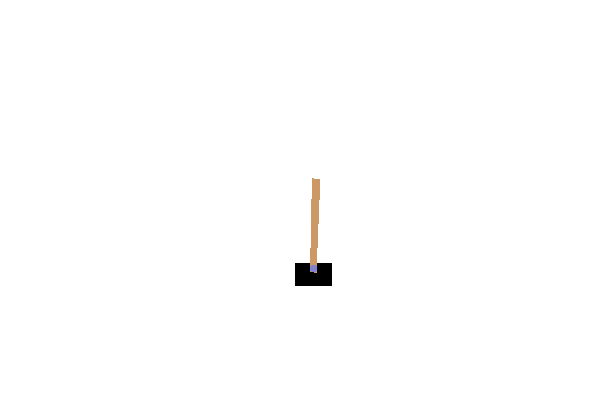
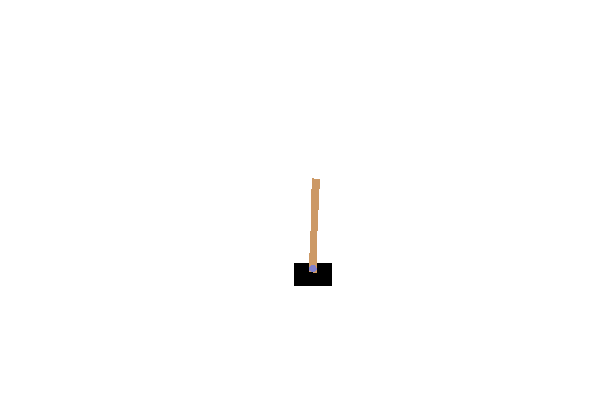
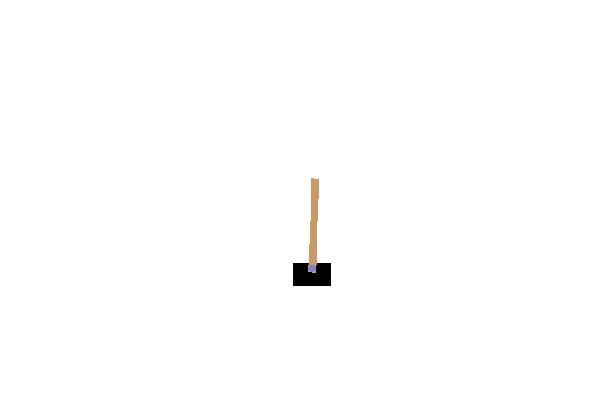
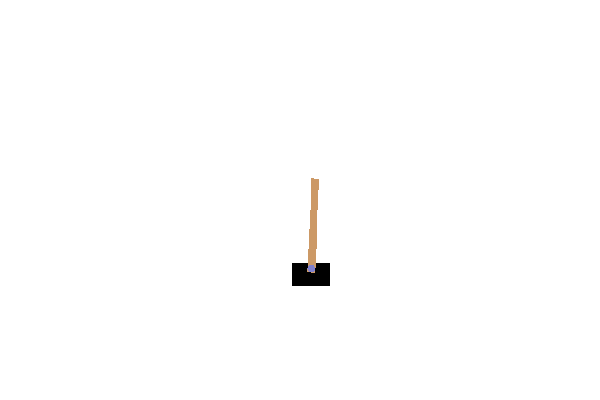
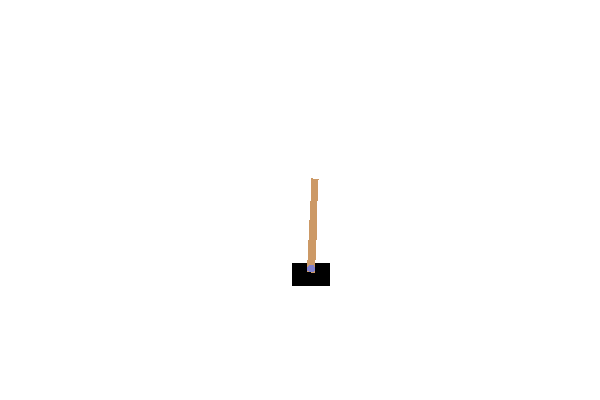
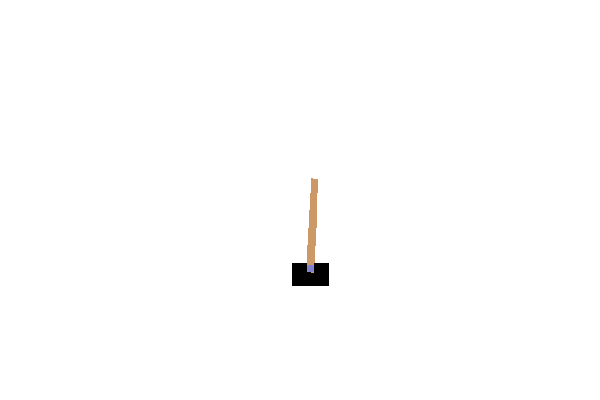
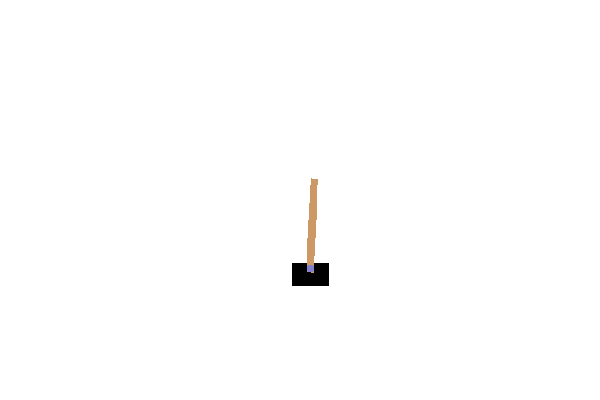
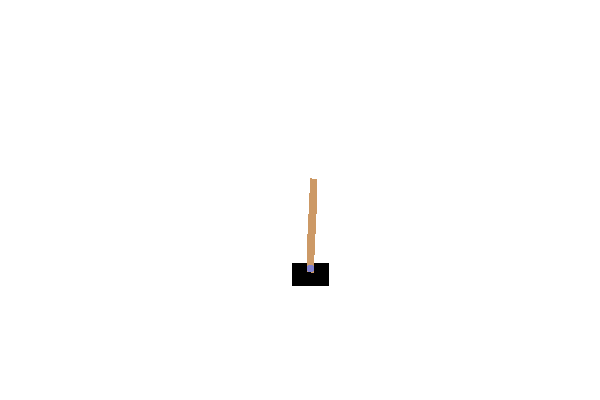
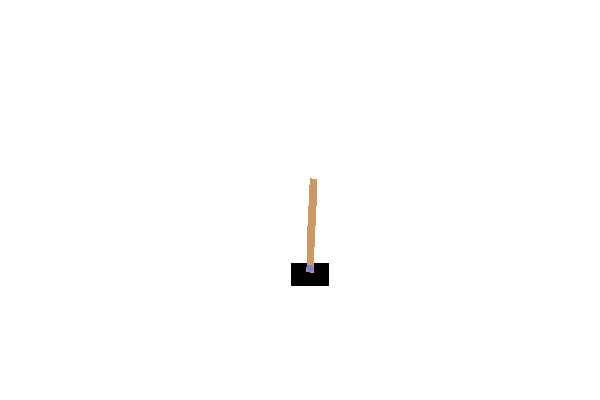
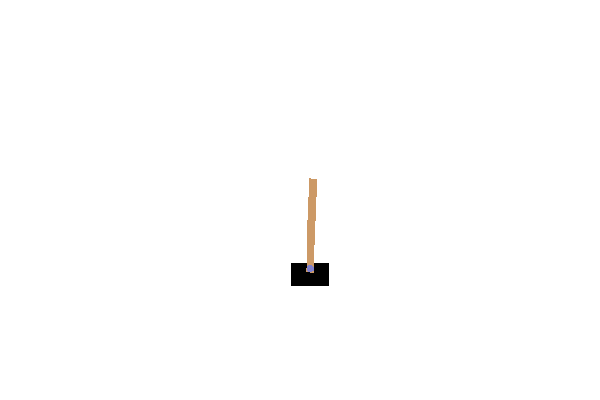
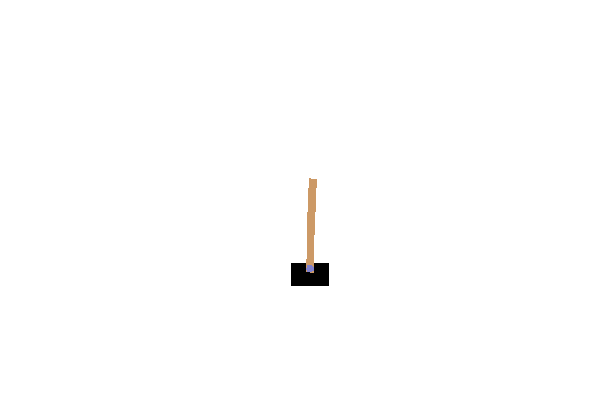
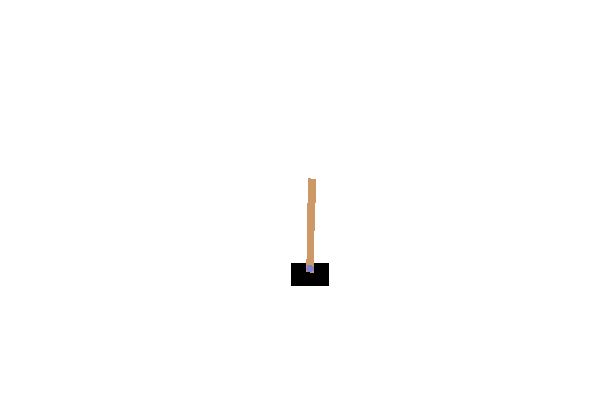
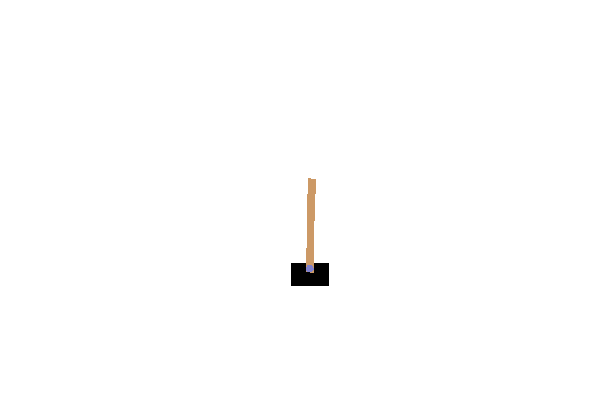
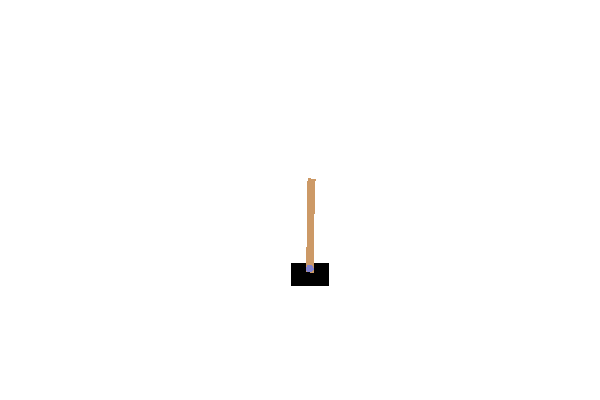
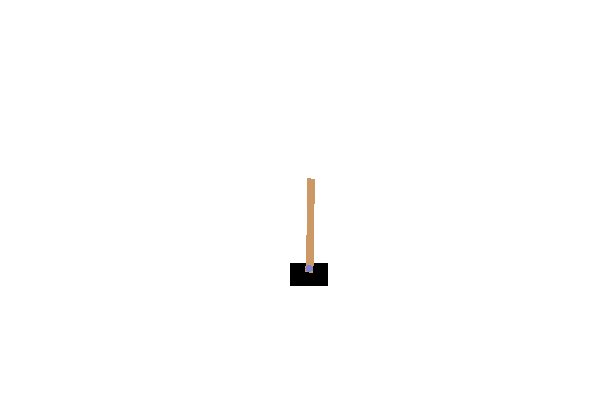
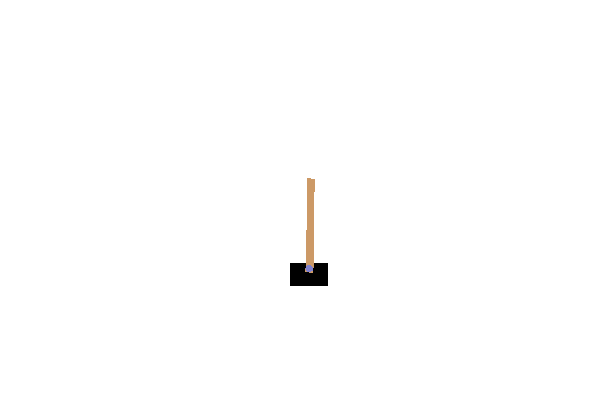
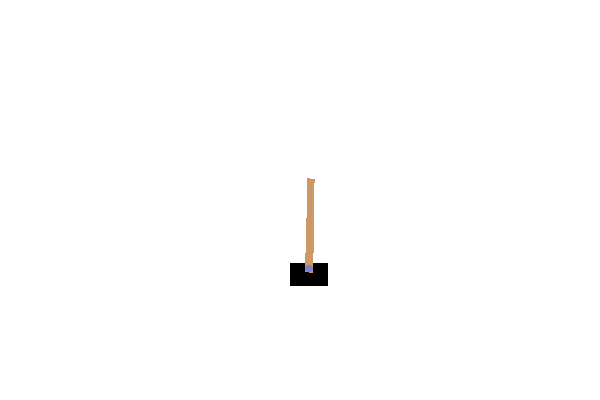
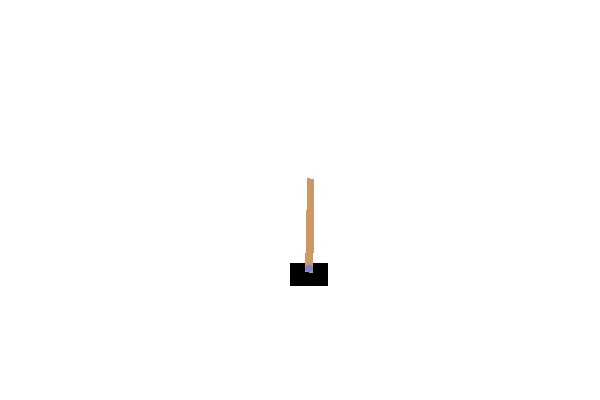

In [10]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()
